## <center>Exploring Customer Segmentation and Customer Lifetime Value for Sales Forecasting</center>
---


In [3]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Import topic modeling packages
# Top2Vec
from top2vec import Top2Vec

# Import customized Top2Vec utility functions
from top2vec_utils import compute_cv_coherence

# Gensim version
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.phrases import Phraser, Phrases
from gensim.models.ldamodel import LdaModel

# Import customized Gensim functions
from gensim_lda import (
    sent_to_words,
    remove_stopwords,
    make_bigrams,
    lemmatization,
    compute_coherence_values,
    format_topics_sentences,
)

# spacy for lemmatization
import spacy

# nltk
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Time Series related packages
import calendar

# Import KModes for segmentation clustering
from kmodes.kmodes import KModes

# ARIMA/SARIMA time series modules
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Import custom ARIMA modules
from arima_utils import (plot_monthly_revenue, train_test_split_time_series, plot_cluster_revenues, 
create_weekly_splits, adf_test_clusters, plot_acf_pacf, plot_residuals_arima, plot_manual_auto_forecasts)

# Import custom modules
from utils import plot_donut_chart, order_issue_words, preprocess_text

c:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Create np random seed
np.random.seed(42)

In [5]:
# Read in data
retail_2009_2010 = pd.read_csv(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\data\online_retail_2009_2010.csv"
)
retail_2010_2011 = pd.read_csv(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\data\online_retail_2010_2011.csv"
)

## Data Preprocessing
---

In [6]:
# Concatenate datasets to create a dataset ranging from 2009-2011
retail_data = pd.concat([retail_2009_2010, retail_2010_2011], axis=0)

### Variable Names and Data Types

In [7]:
# Preview data
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


Let's convert the variable names from camel case to snake case so we can conform with standard python naming conventions.

In [8]:
# Convert all features from camel case to snake case
retail_data.rename(
    columns={
        "Invoice": "invoice",
        "StockCode": "stock_code",
        "Description": "description",
        "Quantity": "quantity",
        "InvoiceDate": "invoice_date",
        "Price": "price",
        "Customer ID": "customer_id",
        "Country": "country",
    },
    inplace=True,
)

In [9]:
# Confirm the feature types
retail_data.dtypes

invoice          object
stock_code       object
description      object
quantity          int64
invoice_date     object
price           float64
customer_id     float64
country          object
dtype: object

There are some descrepancies between what the schema was advertised as and its actual contents. Namely, the `invoice_date` variable is an object but we were told it was datetime and the `customer_id` is provided as a float64 type when we were told it was int64. I think in this context it does make sense to convert `invoice_date` to datetime but it would make more sense to convert `customer_id` to a string object because there is no significance in its ordinality.

In [10]:
# Convert mistyped features: invoice_date and customer_id
retail_data["invoice_date"] = pd.to_datetime(
    retail_data["invoice_date"], format="%m/%d/%Y %H:%M"
)
retail_data["customer_id"] = (
    retail_data["customer_id"].fillna("Not Provided").astype(str)
)  # replace na values with 0

In [11]:
# Confirm newly casted data types
retail_data.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
price                  float64
customer_id             object
country                 object
dtype: object

In [12]:
# Get a quick preview of the data
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Unique Customers

Let's check how many unique customers we have across our 1M+ recorded orders.

In [13]:
# Count unique customers
unique_customer_count = retail_data["customer_id"].nunique()
print(f"There are {unique_customer_count} unique customers in our dataset.")

There are 5943 unique customers in our dataset.


### NA Values and Duplicates

In [14]:
# Check for how many na values are in the dataset
num_nas = retail_data.isna().sum().sum()
print(f"The total number of na values in retail_data is {num_nas}.")

The total number of na values in retail_data is 4382.


In [15]:
# Investigate which features have the majority of na values
na_features_ct = retail_data.isna().sum().reset_index()
na_features_ct = na_features_ct.rename({"index": "feature", 0: "count_na"}, axis=1)
na_features_ct

,feature,count_na
0,invoice,0
1,stock_code,0
2,description,4382
3,quantity,0
4,invoice_date,0
5,price,0
6,customer_id,0
7,country,0


The `description` variable will provide information about the customers and their preferences and has very few missing values (4382). Because our dataset has over 1 million rows, it is safe to remove all missing values for `description`.

In [16]:
# Clean the dataset by dropping all na values of Description
retail_data = retail_data.dropna(subset=["description"])

In [17]:
# Investigate which features have the majority of na values in cleaned dataset
na_features_cleaned_ct = retail_data.isna().sum().reset_index()
na_features_cleaned_ct = na_features_cleaned_ct.rename(
    {"index": "feature", 0: "count_na"}, axis=1
)
na_features_cleaned_ct

,feature,count_na
0,invoice,0
1,stock_code,0
2,description,0
3,quantity,0
4,invoice_date,0
5,price,0
6,customer_id,0
7,country,0


Now all of the na values in our `description` feature have been removed. Let's see if we can find any duplicate values within our dataset.

In [18]:
# Count all duplicate values
duplicate_count = retail_data.duplicated().sum()

# Display the count
print("Number of duplicates:", duplicate_count)

Number of duplicates: 34228


There are 34228 duplicates in this dataset. Let's drop them all because they provide no extra relevant information.

In [19]:
# Drop all duplicates
retail_data = retail_data.drop_duplicates()

### Canceled Transactions

Recall from the 'Data Description' part of the project that the `invoice` variable contains a unique number for each transaction beginning with a 'c' if the transaction was cancelled. Let's see how often transactions are really canceled.

In [20]:
# Create a 'canceled' feature that indicates wheter or not a tranaction was canceled
canceled_transactions = (retail_data["invoice"].str.startswith("C")).sum()
print(
    f"Out of {len(retail_data)} transactions, {canceled_transactions} were canceled\n ({100*(round(canceled_transactions/len(retail_data), 2))}%)"
)

Out of 1028761 transactions, 19104 were canceled
 (2.0%)


We are now going to drop the records where a transaction was canceled because they make up so little of the data.

In [21]:
# Drop rows where 'invoice' starts with 'C'
retail_data = retail_data[~retail_data["invoice"].str.lower().str.startswith("c")]

In [22]:
# Now look at dimensions to make sure all canceled transactions have been dropped
num_dropped_rows = 1028761 - retail_data.shape[0]
print(retail_data.shape)
print(f"{num_dropped_rows} of canceled transactions were dropped.")

(1009657, 8)
19104 of canceled transactions were dropped.


Because the amount of rows we dropped is the same as the number of canceled transactions from earlier, this is confrimation we dropped all canceled transactions from our dataset.

### Outliers/Ambiguous Values

In [23]:
# Check for 'price' and 'quantity' of values negative (nonsensical in terms of transaction)
neg_quantity = (retail_data["quantity"] < 0).sum()
neg_price = (retail_data["price"] < 0).sum()

# Display the result
print(
    f"Count of quantities less than 0: {neg_quantity}\nCount of prices less than 0: {neg_price}"
)

Count of quantities less than 0: 760
Count of prices less than 0: 5


We have 760 `quantity` values that are less than 0 and 5 `price` values less than 0. Since this makes no sense in terms of transactions, we will drop these values. This usually represents items that were returned/cancelled orders. In order to preserve information and keep canceled records while still maintaioning a realistic range for our `quantity` and `price` variables, we will set all `price` and `quantity` values less than 0 to be equal to 0.

In [24]:
# Set'quantity' and 'price' values to be equal to 0 if they are less than 0
retail_data["quantity"] = retail_data["quantity"].apply(lambda x: max(0.0, x))
retail_data["price"] = retail_data["price"].apply(lambda x: max(0.0, x))

# Assign new variales to check for count of 'price' and 'quantity' less than 0
neg_quantity_filtered = (retail_data["quantity"] < 0).sum()
neg_price_filtered = (retail_data["price"] < 0).sum()

print(f"New shape of data: {retail_data.shape}")
# Display the result
print(
    f"Count of quantities less than 0: {neg_quantity_filtered}\nCount of prices less than 0: {neg_price_filtered}"
)

New shape of data: (1009657, 8)
Count of quantities less than 0: 0
Count of prices less than 0: 0


Now that we've dropped entries fitting unreasonable patterns in our numeric data, let's check out our `description` variable to see if there are any entries that are lowercased compared to the majority of uppercased descriptions.

In [25]:
count_descriptions_lower = retail_data["description"].apply(lambda t: t.islower()).sum()
unique_descriptions_lower = (
    retail_data[retail_data["description"].str.islower()]["description"]
    .unique()
    .tolist()
)
print(f"The count of lowercased descriptions is {count_descriptions_lower}")

The count of lowercased descriptions is 725


725 lowercased descriptions is a decent amount. Let's see if we can find any patterns among these lowercased entries.

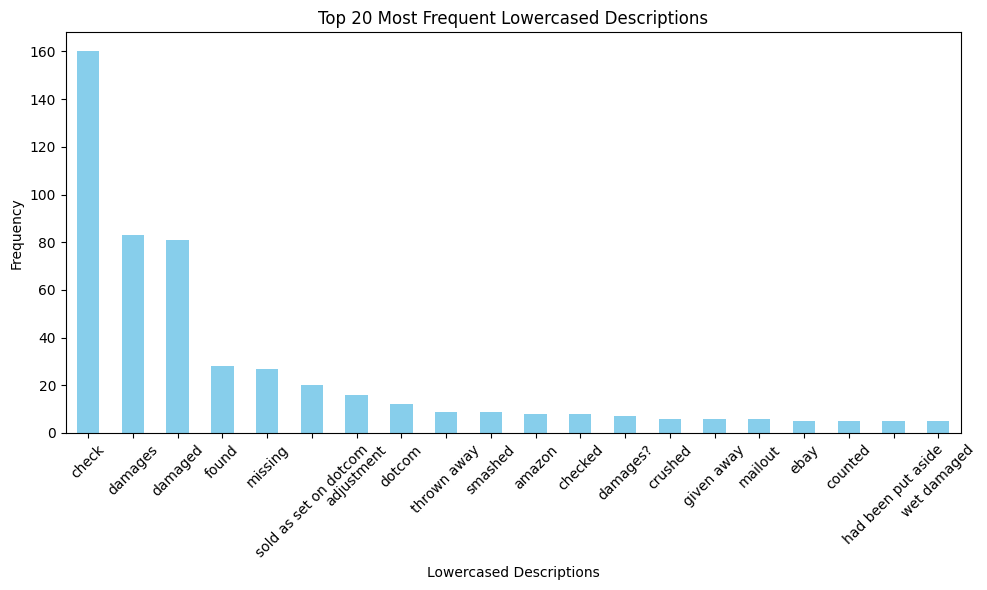

In [26]:
# # Sort the phrases by count in descending order
descriptions_lower = retail_data[
    retail_data["description"].apply(lambda t: t.islower())
]["description"].value_counts()

# # Plot the histogram
plt.figure(figsize=(10, 6))
descriptions_lower[:20].plot(kind="bar", color="skyblue")
plt.title("Top 20 Most Frequent Lowercased Descriptions")
plt.xlabel("Lowercased Descriptions")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Determine proportion of lowercased descriptions visible in histogram
count_lower_descriptions = descriptions_lower[:20].sum()
proportion_lower_descriptions = round(100 * (count_lower_descriptions / 725), 2)
print(
    f"The total number of lowercased descriptions in our histogram is {count_lower_descriptions}, making up\n{proportion_lower_descriptions}% of all lowercased descriptions."
)

The total number of lowercased descriptions in our histogram is 506, making up
69.79% of all lowercased descriptions.


Looking at this histogram, the majority of these lowercase listings indicate that a product was either damaged, missing, or categorized as something else. There are so few of these instances though that it is best to just remove them given that we have 1M+ rows of data to work with in total.

In [28]:
# Remove the lowercase descriptions from the original DataFrame
retail_data = retail_data[~retail_data["description"].apply(lambda t: t.islower())]

In [29]:
new_lower_count = retail_data["description"].apply(lambda t: t.islower()).sum()
print(f"The new count of lowercase descriptions is {new_lower_count}")

The new count of lowercase descriptions is 0


Now that we've removed all lowercased descriptions because they typically indicated damaged/missing items, let's see if we can find any of the words in the lowercased list `unique_descriptions_lower` that the rest of our uppercase descriptions may contain. If the people who record these transactions have somewhat of a structure, I expect to see some repeated patterns for uppercased listing.

In [30]:
# Filter descriptions that match unique lowercase descriptions
matching_descriptions = retail_data[
    retail_data["description"].str.lower().isin(unique_descriptions_lower)
]["description"]
count_matching_descriptions = matching_descriptions.count()
# Display the matching descriptions
print(count_matching_descriptions)

70


It looks like we found 70 results in our `description` variable that was not fully lowercased which matched words in our lowercased entries (all indicating missing items). Let's check out the distributions of the most common of these descriptions.

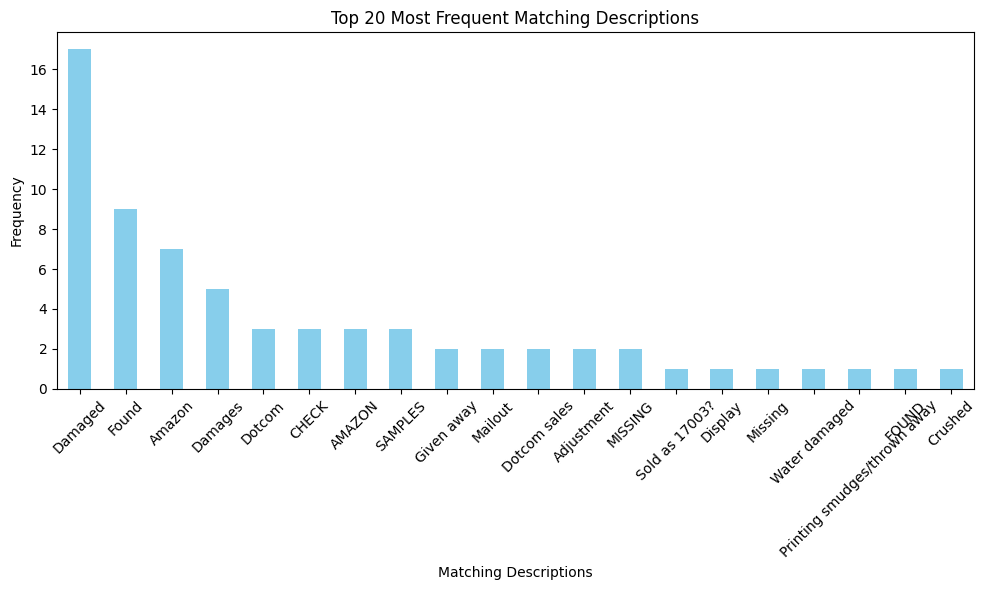

In [31]:
# # Sort the phrases by count in descending order
matching_counts = retail_data[
    retail_data["description"].str.lower().isin(unique_descriptions_lower)
]["description"].value_counts()

# # Plot the histogram
plt.figure(figsize=(10, 6))
matching_counts[:20].plot(kind="bar", color="skyblue")
plt.title("Top 20 Most Frequent Matching Descriptions")
plt.xlabel("Matching Descriptions")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Seems like the same story, mostly damaged/missing items for non-lowercased descriptions with the same words typically contained in lowercase. Therefore, we will delte these entries.

In [32]:
# Remove the matching descriptions with lowercased (damaged/missing) from the original DataFrame
retail_data = retail_data[
    ~retail_data["description"].str.lower().isin(unique_descriptions_lower)
]
new_count_matching_descriptions = retail_data[
    retail_data["description"].str.lower().isin(unique_descriptions_lower)
]["description"].count()
print(
    f"The new count of rows that match lowercase descriptions is {new_count_matching_descriptions}"
)

The new count of rows that match lowercase descriptions is 0


The last pattern I am seeing is that descriptions indicating that an item is damaged/missing, regardless of casing, tend to be shorter on average (I'd say about 1 word). For a final check I am going to take a look at how many descriptions we have that are one word and then look at the most common examples for those descriptions.

In [33]:
# Count descriptions with two words or less
count_short_descriptions = (
    retail_data["description"].apply(lambda x: len(x.split())) <= 1
).sum()
print(f"The count of descriptions that have one word is: {count_short_descriptions}")

The count of descriptions that have one word is: 3222


This is a decent amount of descriptions that have one word (3222). I think it would be very difficult to describe most items in two words or less so I am going to check the distribution of these kinds of descriptions to see if I can detect any trends.

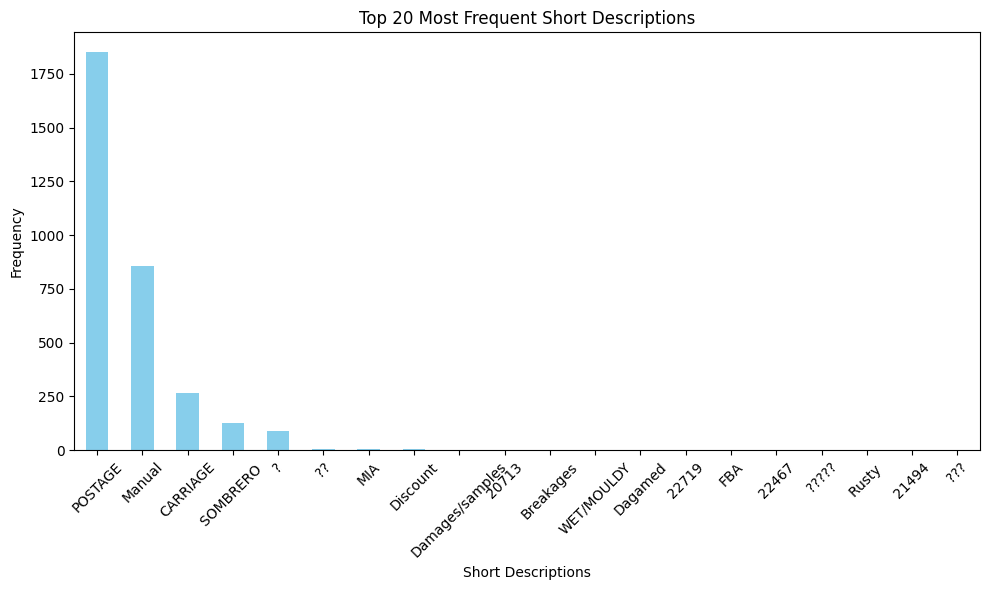

In [34]:
# # Sort the phrases by count in descending order
short_descriptions = retail_data[
    retail_data["description"].apply(lambda x: len(x.split())) <= 1
]["description"].value_counts()

# # Plot the histogram
plt.figure(figsize=(10, 6))
short_descriptions[:20].plot(kind="bar", color="skyblue")
plt.title("Top 20 Most Frequent Short Descriptions")
plt.xlabel("Short Descriptions")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Though Sombrero is a valid item, the rest of these descriptions describe missing/damaged items or random punctuation/digits/acronyms like '?' '20713', or MIA. We also see the most common one word listing is 'Postage' which is probably referring to the cost associated with mailing or shipping a product (gives us no context on what the product is so on't be useful for our segmentation analysis). Because this is such a small sample of our total dataset and it will be difficult to make semantic comparisons based off of one word, I will remove all of these records.

In [35]:
# Remove all words descriptions that are one word or less
retail_data = retail_data[
    retail_data["description"].apply(lambda x: len(x.split()) > 1)
]
new_count_short_descriptions = (
    retail_data["description"].apply(lambda x: len(x.split()) <= 1)
).sum()
print(
    f"The new count of descriptions that are one word or less is: {new_count_short_descriptions}"
)

The new count of descriptions that are one word or less is: 0


In the last one word or less `description` analysism I notices that there are random numbers and punctuation ('??', '20713'). Because these types of descriptions will make semantic topic modeling difficult, I am going to see how many instances I can find of descriptions that contain no english letters in them and then look at the distribution of the most common descriptions of this type.

In [36]:
# Use regex to find rows without English letters or words
count_no_letters = retail_data[~retail_data["description"].str.contains(r"[a-zA-Z]")][
    "description"
].count()
print(
    f"The count of descriptions that contain no English letters is {count_no_letters}"
)

The count of descriptions that contain no English letters is 0


For my final step, I am going to see how many longer descriptions contain words in the invalid rows I found before and I will analyze the distribution of these rows.

In [37]:
# Create a list of all unique invalid values and convert them to lowercase
descriptions_lower_list = descriptions_lower.index.tolist()
short_descriptions_list = short_descriptions.index.str.lower().tolist()
invalid_descriptions = set(descriptions_lower_list + short_descriptions_list)

# Use regex to find rows without English letters or words
pattern = "|".join(re.escape(description) for description in invalid_descriptions)
contains_invalid_count = (
    retail_data["description"].str.lower().str.contains(pattern, case=False)
).sum()

print(
    f"The count of descriptions that contain Invlaid words/phrases is {contains_invalid_count}"
)

The count of descriptions that contain Invlaid words/phrases is 3178


Now that we know 3178 of our descriptions contain invalid words within them, let's see what the distribution of these descriptions are.

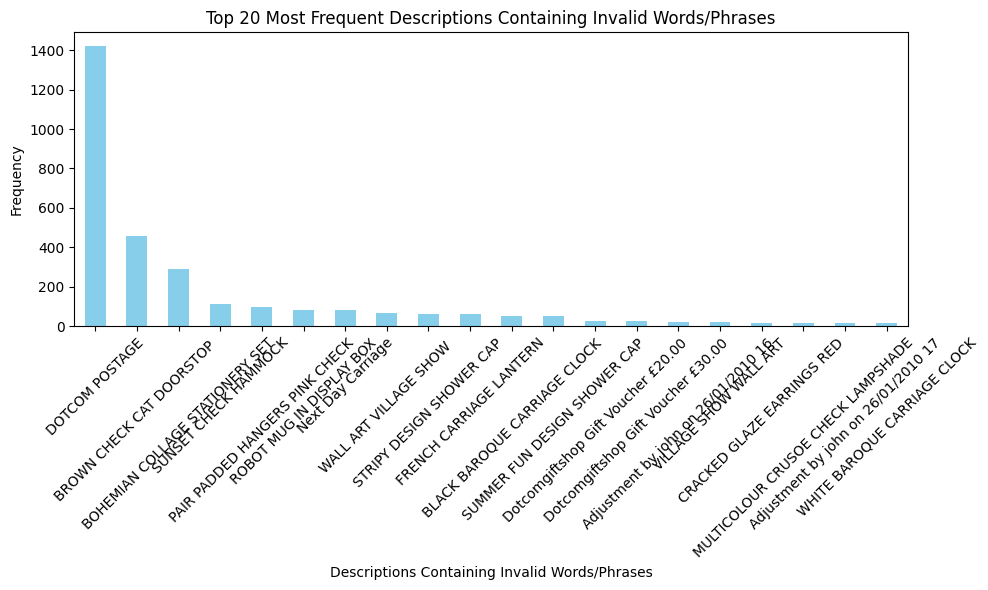

In [38]:
# # Sort the phrases by count in descending order
contains_invalid_descriptions = retail_data[
    retail_data["description"].str.lower().str.contains(pattern, case=False)
]["description"].value_counts()

# # Plot the histogram
plt.figure(figsize=(10, 6))
contains_invalid_descriptions[:20].plot(kind="bar", color="skyblue")
plt.title("Top 20 Most Frequent Descriptions Containing Invalid Words/Phrases")
plt.xlabel("Descriptions Containing Invalid Words/Phrases")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In this list, there are some descriptions that clearly are invalid and don't give us context about the specific product (like "DOTCOM POSTAGE" or "Next Day Carriage") and others that are valid (like "BROWN CHECK CAT DOORSTOP" and "STRIPY DESIGN SHOWER CAP"). To mitigate this issue, I will make a list of all of the invalid descriptions I see and will drop them.

In [39]:
# Create a list by manually entering invalid descriptions shown in historgram distribution
flagged_descriptions = [
    "dotcom postage",
    "next day carriage",
    "dotcomgiftshop gift voucher £20.00",
    "dotcomgiftshop gift voucher £30.00",
    "adjustment by john on 26/01/2010 16",
    "adjustment by john on 26/01/2010 17",
    'sold as a/b',
    "dotcomgiftshop gift voucher £80.00",
    "dotcomgiftshop gift voucher",
    "dotcomgiftshop",
    "found in"
]

# Use regex to create flagged_pattern
flagged_pattern = "|".join(
    re.escape(description) for description in flagged_descriptions
)

# Drop rows where the lowercased description matches any flagged description
retail_data = retail_data[
    ~retail_data["description"].str.lower().str.contains(flagged_pattern, case=False)
]

# Display how many rows we initially categorized as invalid after this operation
contains_invalid_count_new = (
    retail_data["description"].str.lower().str.contains(pattern, case=False)
).sum()

print(
    f"The new count of descriptions that contain Invlaid words/phrases is {contains_invalid_count_new}"
)

The new count of descriptions that contain Invlaid words/phrases is 1550


There are still some rows counted as Invalid words/phrases but this is alright because not all of the descriptions we found containing valid words/phrases were actually invalid.  

One last thing I want to do is to cross reference a list of terms that I found online or that I thought could indicate an error in the transaction and/or missing/canceled shipments. (This list is called `order_issue_words` imported from utils.py)
 

In [40]:
# List all words/phrases that might indicate an error with the transaction

# convert all issues to lowercase to avoid case sensitivity
order_issue_words = [word.lower() for word in order_issue_words]

# Check to see how many descriptions contain these strings indicating an order issue with regex
pattern_issue = "|".join(re.escape(issue) for issue in order_issue_words)
contains_issue_count = (
    retail_data["description"].str.lower().str.contains(pattern_issue, case=False)
).sum()
print(f"The count of descriptions containing an order issue is {contains_issue_count}")

The count of descriptions containing an order issue is 10


Since the count of our custom issues is so few (10), we'll drop them.

In [41]:
# Drop rows where the lowercased description matches any order issue
retail_data = retail_data[
    ~retail_data["description"].str.lower().str.contains(pattern_issue, case=False)
]

## Feature Engineering
---

First off, we need to create the value we are going to be forecasting - revenue. Recall from any economics course:  
$$
Revenue = Price * Quantity
$$

In [42]:
# Create a revenue value
retail_data["revenue"] = round(retail_data["price"] * retail_data["quantity"], 2)

In [43]:
# Preview data with added 'revenue' column
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


Looking at our dataset, there are four feature changes I want to make: `price`, `invoice_date`, `quantity`, and `description`. I plan on categorizing `quantity` and `price` by using 'very low', 'low', 'medium', and 'high' bins and breaking `invoice_date` by months so I can get a general trend of how seasonality influences sales. I also plan on using clustering to categorize the `description` feature.  

Before doing any bucketing, we need to make sure that our continuous variables `price` and `quantity` are normally distributed first.

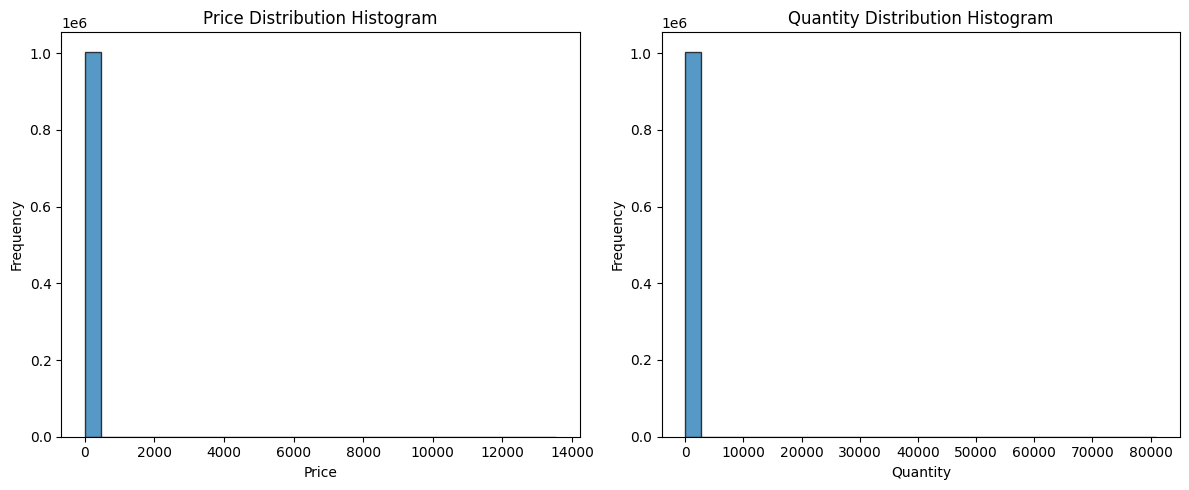

In [44]:
import matplotlib.pyplot as plt

# Set the figure size and create subplots
plt.figure(figsize=(12, 5))

# Create a subplot for the 'price' variable
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(retail_data["price"], bins=30, edgecolor="k", alpha=0.75)
plt.title("Price Distribution Histogram")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Create a subplot for the 'quantity' variable
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(retail_data["quantity"], bins=30, edgecolor="k", alpha=0.75)
plt.title("Quantity Distribution Histogram")
plt.xlabel("Quantity")
plt.ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

These histograms indicate that both of our `quantity` and `price` variables are very skewed with most of the distbituion lying near zero. This indicates that there are most likely outliers causing this skew.

Now we will make a scatterplot to see how many outliers there are and whether or not it is appropriate to remove them.

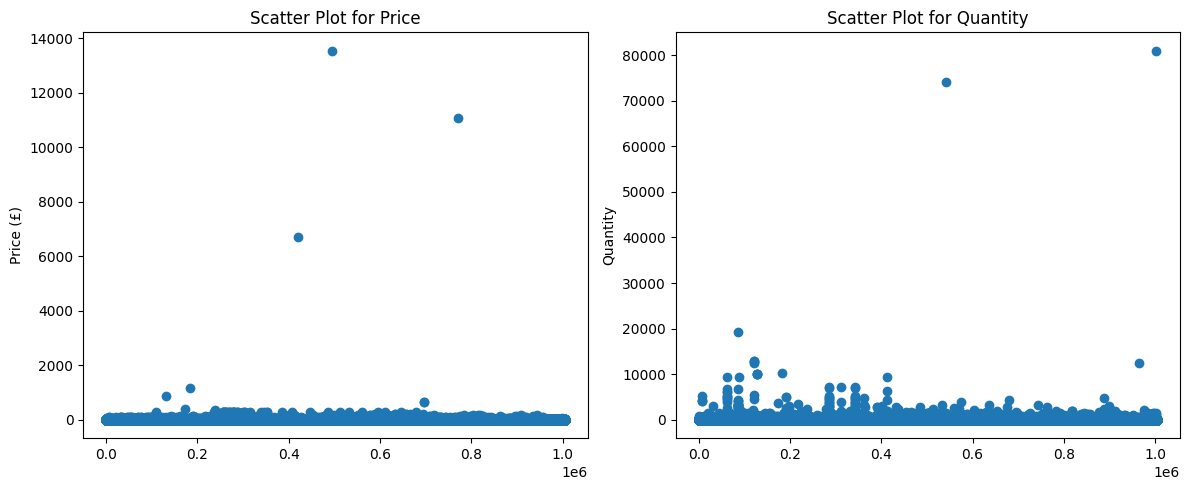

In [45]:
# Create a Scatter plot figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 'price' (scatter plot) on the first subplot
ax1.scatter(range(len(retail_data["price"])), retail_data["price"])
ax1.set_title("Scatter Plot for Price")
ax1.set_ylabel("Price (£)")  # Set the y-label for the first subplot

# Plot 'quantity' (scatter plot) on the first subplot
ax2.scatter(range(len(retail_data["quantity"])), retail_data["quantity"])
ax2.set_title("Scatter Plot for Quantity")
ax2.set_ylabel("Quantity")  # Set the y-label for the second subplot

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

Though there are outliers in both the `price` and `quantity` variables, I think that it is reasonable for a store to sell very high priced items and high quantities because they are selling to wholesalers, retail stores, and resellers who can definitely afford to buy this kind of quantity and price.  

Next, we'll check to see the exact records where the `price` was greater than 2,000£ and separately where `quantity` was greater than 15,000 items.

In [46]:
# Looking at specific instances of our continuous outliers for price and quantity
outliers_df = retail_data[
    (retail_data["quantity"] > 15000) | (retail_data["price"] > 2000)
]
outliers_df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152.0,2010-02-15 11:57:00,0.10,13902.0,Denmark,1915.20
440698,531411,AMAZONFEE,AMAZON FEE,1.0,2010-11-08 10:11:00,6706.71,Not Provided,United Kingdom,6706.71
517955,537632,AMAZONFEE,AMAZON FEE,1.0,2010-12-07 15:08:00,13541.33,Not Provided,United Kingdom,13541.33
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
299982,A563185,B,Adjust bad debt,1.0,2011-08-12 14:50:00,11062.06,Not Provided,United Kingdom,11062.06


These outliers for `quantity` seem reasonable but the outliers for `price` do not. The most expensive items are labeled 'AMAZON FEE' which probably means the company has incurred charges from doing their business on the Amazon platform. The `quantity` values that are high seem like reasonable purchases because the customers are typically retail stores or whole salers. Because an Amazon fee gives us no context about an actual product purchased, we will remove all price values greater than 2000£. One thing I am also noticing is that all of the problematic records in this outliers_df subset have the `customer_id` equal to 'Not Provided'. I am going to take a closer look at all of the `customer_id` column values with the value 'Not Provided' to see if I could safely remove them.


In [47]:
# Subset retail_data to only contain rows less than 2000£
retail_data = retail_data[retail_data["price"] < 2000]

In [48]:
# Get a count of total rows where 'customer_id' is set as 'Not Provided'
not_provided_df = retail_data[
    retail_data["customer_id"].str.lower().str.contains("not provided")
]
count_not_provided = not_provided_df["customer_id"].count()
print(f"For all `customer_id` labels, {count_not_provided} are labeled 'Not Provided'")

For all `customer_id` labels, 227501 are labeled 'Not Provided'


That is a ton of 'Not Provided' `customer_id` entries! Let's take a look at some of the most common descriptions of this `customer_id` type

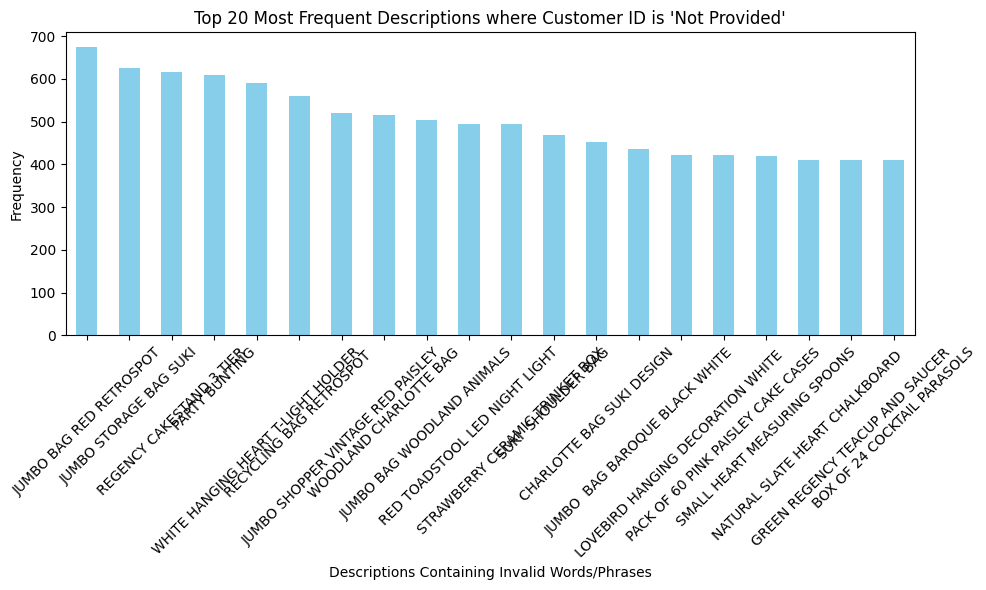

In [49]:
# Get counts of descriptions with customer_id labeled 'Not Provided'
descriptions_not_provided = not_provided_df["description"].value_counts()

# # Plot the histogram
plt.figure(figsize=(10, 6))
descriptions_not_provided[:20].plot(kind="bar", color="skyblue")
plt.title("Top 20 Most Frequent Descriptions where Customer ID is 'Not Provided'")
plt.xlabel("Descriptions Containing Invalid Words/Phrases")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

All of these seem reasonable for 'Not Provided' Customer IDs, so we will not remove anything here. The last thing I want to look at is count of records where the `quantity` sold is equal to 0. 


In [50]:
# Get a count of the number of rows where quantity is zero
zero_quantity_df =  retail_data[retail_data['quantity']==0]
count_zero_quantity = zero_quantity_df['quantity'].count()
print(f"The count of quantities recorded as '0' is {count_zero_quantity}")

The count of quantities recorded as '0' is 43


Let's take a look at the descriptions where `quantity` is marked as '0'.

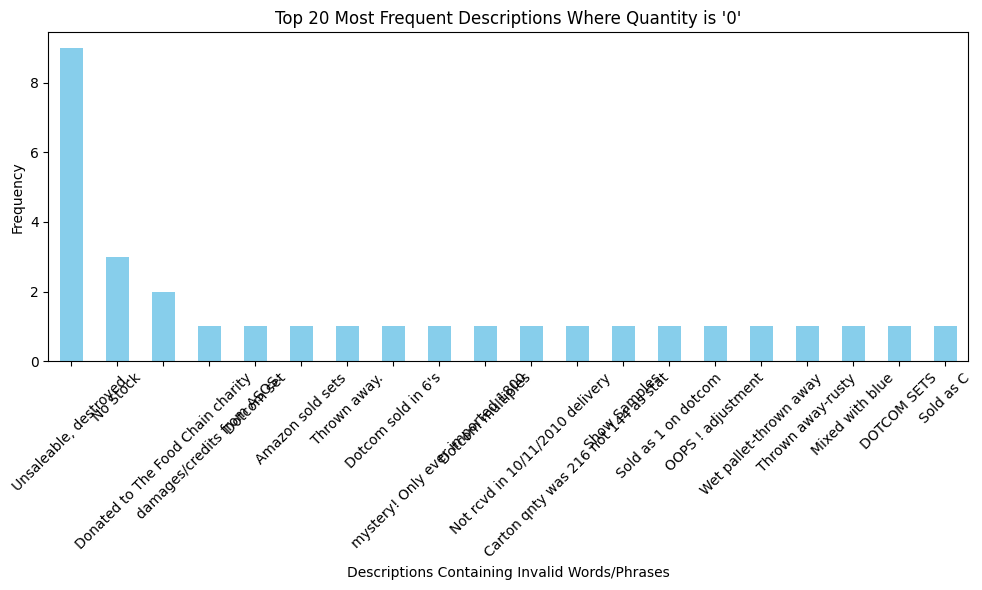

In [51]:
# Get counts of descriptions with quantity labeled '0'
quantity_zero_descriptions = zero_quantity_df["description"].value_counts()

# # Plot the histogram
plt.figure(figsize=(10, 6))
quantity_zero_descriptions[:20].plot(kind="bar", color="skyblue")
plt.title("Top 20 Most Frequent Descriptions Where Quantity is '0'")
plt.xlabel("Descriptions Containing Invalid Words/Phrases")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

These are all listed as errors wo we will drop all of these.

In [52]:
# Drop all rows where quantity is '0'
retail_data = retail_data[~(retail_data['quantity']==0)]
count_zero_quantity_new = retail_data[retail_data['quantity']==0]['quantity'].count()
print(f"The new count of records where the quantity is '0' is {count_zero_quantity_new}")

The new count of records where the quantity is '0' is 0



Because our distributions for `price` and `quantity` are heavily right-skewed, we are going to adjust this distribution with a log to try to make the distribution more normal for categorical binning later.

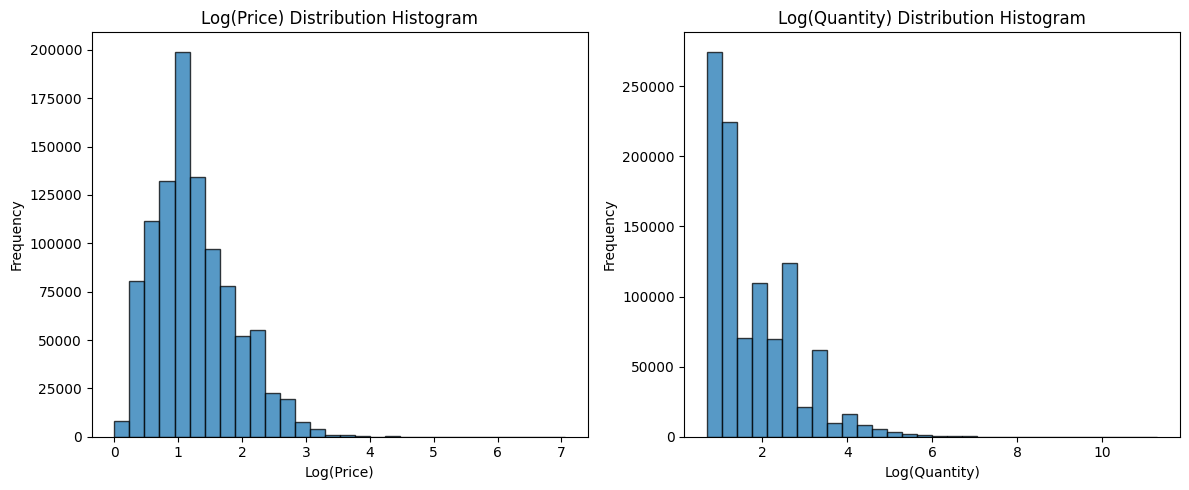

In [53]:
# Apply the natural logarithm to 'quantity' and 'price'
log_quantity = np.log1p(retail_data["quantity"])  # Add 1 to avoid log(0)
log_price = np.log1p(retail_data["price"])  # Add 1 to avoid log(0)

# Set the figure size and create subplots
plt.figure(figsize=(12, 5))

# Create a subplot for the 'log(price)' variable
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(log_price, bins=30, edgecolor="k", alpha=0.75)
plt.title("Log(Price) Distribution Histogram")
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")

# Create a subplot for the 'log(quantity)' variable
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(log_quantity, bins=30, edgecolor="k", alpha=0.75)
plt.title("Log(Quantity) Distribution Histogram")
plt.xlabel("Log(Quantity)")
plt.ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

The distribution is still slightly right skewed for both Log(Price) and Log(Quantity) but not nearly as extreme before we applied a log transformation. This will make our binning much easier (and less skewed) when trying to make these variables categorical so we will create new log transformed variables of `price` and `quantity`.

In [54]:
# Create new log transformed (base e of '1+x') variables of 'price' and 'quantity'
retail_data["log_price"] = np.log1p(retail_data["price"])
retail_data["log_quantity"] = np.log1p(retail_data["quantity"])

# To stay consistent, we will also create a log transformed 'revenue' variable
retail_data["log_revenue"] = np.log1p(retail_data["revenue"])

In [55]:
# Check to make sure our new variables look how we expect
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987


In [56]:
6.931472e-01	

0.6931472

In [57]:
# Get summary statistics of continuous features
retail_data.describe()

,quantity,invoice_date,price,revenue,log_price,log_quantity,log_revenue
count,1.003955e+06,1003955,1.003955e+06,1.003955e+06,1.003955e+06,1.003955e+06,1.003955e+06
mean,1.117463e+01,2011-01-04 10:24:35.173768192,3.338058e+00,1.955442e+01,1.243350e+00,1.723812e+00,2.351955e+00
min,1.000000e+00,2009-12-01 07:45:00,0.000000e+00,0.000000e+00,0.000000e+00,6.931472e-01,0.000000e+00
25%,1.000000e+00,2010-07-06 11:21:00,1.250000e+00,4.130000e+00,8.109302e-01,6.931472e-01,1.635106e+00
50%,4.000000e+00,2010-12-09 15:16:00,2.100000e+00,1.004000e+01,1.131402e+00,1.609438e+00,2.401525e+00
75%,1.200000e+01,2011-07-28 12:50:00,4.130000e+00,1.770000e+01,1.635106e+00,2.564949e+00,2.928524e+00
max,8.099500e+04,2011-12-09 12:50:00,1.157150e+03,1.684696e+05,7.054579e+00,1.130216e+01,1.203452e+01
std,1.297735e+02,NaN,4.780797e+00,1.999069e+02,6.176854e-01,9.971609e-01,1.002106e+00


Our continuous variables `log_quantity` and `log_price` are fairly well spread out across all quartiles. Here, it makes no sense to look at the summary statistics of `invoice_date` for binning so we'll ignore that for now.  

`log_quantity`: 
* Min: 0.0.69 log(1 + items) &asymp; 0.0 items
* 25th percentile: 0.69 log(1+ items) &asymp; 1.0 items
* 50th percentile (median): 1.61 log(1 + items) &asymp; 4.0 items
* 75th percentile: 2.56 log(1 + items) &asymp; 12.0 items
* Max: 11.30 log(1 + items) &asymp; 80994.79 items

`log_price`:
* Min: 0.00 log(1 + £) &asymp; 0.0£
* 25th percentile: 0.81 log(1+ £) &asymp; 1.25£
* 50th percentile (median): 1.13 log(1 + £) &asymp; 2.10£
* 75th percentile: 1.64 log(1+ £) &asymp; 4.13£
* Max: 7.05 log(1+ £)  &asymp; 1157.14£

<u>*Approach*</u>:   
* 'very low': Values betwen the min and 25th percentile (min to Q1)
* 'low': Values between the 25th and 50th percentile (Q1 to Q2)
* 'medium': Values between the 50th and 75th percentile (Q2 to Q3)
* 'high': Values greater than or equal to the 75th percentile (Q3)


In [58]:
# Define the bin edges and labels for 'quantity' and 'price'
log_quantity_bin_edges = [0.69, 1.61, 2.56, 11.31] # Only three bins for quantity because anything less than 1 item is nonsensical
log_price_bin_edges = [0, 0.81, 1.13, 1.64, 7.06]
log_quantity_bin_labels = [
    "low_quantity",
    "medium_quantity",
    "high_quantity"
]
log_price_bin_labels = ["very_low_price", "low_price", "medium_price", "high_price"]

# Use pd.cut() to categorize the 'quantity' and 'price' columns
retail_data["quantity"] = pd.cut(
    retail_data["log_quantity"],
    bins=log_quantity_bin_edges,
    labels=log_quantity_bin_labels,
    include_lowest=True,
)
retail_data["price"] = pd.cut(
    retail_data["log_price"],
    bins=log_price_bin_edges,
    labels=log_price_bin_labels,
    include_lowest=True,
)

Though it seems strange to use a different number of bins for `quantity` and `price`, I think that it is justified to use one extra bin of 'very_low' for price because a price can be fractions of a pound but we assuume a quantity cannot be fractional. Because the minimum and 25th percentile are both 1, we lose a bin as well for `quantity` 

In [59]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567
1,489434,79323P,PINK CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719
2,489434,79323W,WHITE CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,medium_price,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987


In [60]:
# Check for missing values after binning in 'quantity'
quantity_counts_na = retail_data["quantity"].isna().sum()
print(f"There are {quantity_counts_na} missing values for the `quantity` column.")

# Check for missing values after binning in 'price'
price_counts_na = retail_data["price"].isna().sum()
print(f"There are {price_counts_na} missing values for the `price` column.")

There are 0 missing values for the `quantity` column.
There are 0 missing values for the `price` column.


Looking better. Now, let's create a variable called `month` so that in addition to the datetime timestamp, we can also analyze how customer behavior changes by month/season.

In [61]:
# Create a new 'month' column
retail_data["month"] = retail_data["invoice_date"].dt.strftime("%B")

In [62]:
# Preview updated dataframe
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue,month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567,December
1,489434,79323P,PINK CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December
2,489434,79323W,WHITE CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,medium_price,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010,December
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987,December


Now, let's take a look at our distribution for `country` and see if we need to do any modifications.

In [63]:
# Looking at our distribution of country
country_counts = retail_data["country"].value_counts()
print(country_counts)

country
United Kingdom          924164
EIRE                     16918
Germany                  15792
France                   13159
Netherlands               4986
Spain                     3561
Switzerland               3069
Belgium                   2912
Portugal                  2409
Australia                 1786
Channel Islands           1544
Italy                     1411
Sweden                    1285
Norway                    1264
Cyprus                    1132
Finland                    985
Austria                    888
Denmark                    756
Unspecified                748
Greece                     653
Poland                     498
Japan                      468
United Arab Emirates       462
USA                        404
Israel                     366
Hong Kong                  347
Singapore                  332
Malta                      277
Canada                     227
Iceland                    222
RSA                        166
Lithuania                  154


In [64]:
# Calculate the proportion of U.K. countries for all recorded transactions
prop_uk = country_counts = round(
    100
    * (
        retail_data["country"].value_counts().iloc[0]
        / retail_data["country"].value_counts().sum()
    ),
    2,
)
print(f"The U.K. makes up {prop_uk}% of all country entries.")

The U.K. makes up 92.05% of all country entries.


Immediately, we see that the overwhelming majority is U.K. (92.05%) To make things simpler for our model in the future, we are going to just drop all non-U.K. countries because it is unlikely they will influence our clusters or timeseries forecasting later on.

In [65]:
# Dropping all rows in 'country' not equal to "United Kingdom"
retail_data = retail_data[
    retail_data["country"].str.lower() == "United Kingdom".lower()
]
print(retail_data.shape)

(924164, 13)


After dropping non-U.K. countries, we have less than a million rows.

### Creating an RFM Score For Each Customer  

RFM stands for "Recency, Frequency, Monetary Value". In a business analytics context, we use this concept to divide customers into segments (i.e. high-value, low-value, and medium-value customers). For any given business, the RFM analysis creates a criteria of evaluation with these definitions of each componenet:  
1. *Recency*: How recently the customer made a transaction with the business.
1. *Frequency*: How frequent the customer is in ordering/buying some product.
1. *Monetary*: How much the customer spends on purchasing products.  

First, let's calculate recency for customers who had made a purchase.

In [66]:
# Calculating recency scores
df_recency = retail_data.groupby("customer_id", as_index=False)["invoice_date"].max()
df_recency.columns = ["customer_id", "last_purchase_date"]
recent_date = df_recency["last_purchase_date"].max()
df_recency["recency"] = df_recency["last_purchase_date"].apply(
    lambda x: (recent_date - x).days
)
df_recency.head()

,customer_id,last_purchase_date,recency
0,12346.0,2011-01-18 10:01:00,325
1,12608.0,2010-10-31 10:49:00,404
2,12745.0,2010-08-10 10:14:00,486
3,12746.0,2010-06-17 10:41:00,540
4,12747.0,2011-12-07 14:34:00,1


Now, that we have our recency scores, let's calculate scores for frequenc scores for how frequent transactions are of a given customer ordering some product from the company.

In [67]:
# Calculating frequency scores
frequency_df = (
    retail_data.drop_duplicates()
    .groupby("customer_id", as_index=False)["invoice_date"]
    .count()
)
frequency_df.columns = ["customer_id", "frequency"]
frequency_df.head()

,customer_id,frequency
0,12346.0,34
1,12608.0,16
2,12745.0,22
3,12746.0,17
4,12747.0,249


Finally, let's calculate the monetary value of customer spend on purchasing products from the company.

In [68]:
# Calculating monetary scores
monetary_df = retail_data.groupby("customer_id", as_index=False)["revenue"].sum()
monetary_df.columns = ["customer_id", "monetary"]
monetary_df.head()

,customer_id,monetary
0,12346.0,77556.46
1,12608.0,415.79
2,12745.0,723.85
3,12746.0,254.55
4,12747.0,8898.48


We will now merge all three columns into one dataframe.

In [69]:
# Merge recency, frequency, and monetary values into one dataframe
rf_df = df_recency.merge(frequency_df, on="customer_id")
rfm_df = rf_df.merge(monetary_df, on="customer_id").drop(columns="last_purchase_date")
rfm_df.head()

,customer_id,recency,frequency,monetary
0,12346.0,325,34,77556.46
1,12608.0,404,16,415.79
2,12745.0,486,22,723.85
3,12746.0,540,17,254.55
4,12747.0,1,249,8898.48


Now, we will normalize the rank of the customers within the company for recency, frequency, and monetary score and analyze those rankings.

In [70]:
# Analyze the normalized ranks of recency, frequency, and monetary scores
rfm_df["r_rank"] = rfm_df["recency"].rank(ascending=False)
rfm_df["f_rank"] = rfm_df["frequency"].rank(ascending=True)
rfm_df["m_rank"] = rfm_df["monetary"].rank(ascending=True)

# normalizing the rank of the customers
rfm_df["r_rank_norm"] = (rfm_df["r_rank"] / rfm_df["r_rank"].max()) * 100
rfm_df["f_rank_norm"] = (rfm_df["f_rank"] / rfm_df["f_rank"].max()) * 100
rfm_df["m_rank_norm"] = (rfm_df["m_rank"] / rfm_df["m_rank"].max()) * 100

rfm_df.drop(columns=["r_rank", "f_rank", "m_rank"], inplace=True)

rfm_df.head()

,customer_id,recency,frequency,monetary,r_rank_norm,f_rank_norm,m_rank_norm
0,12346.0,325,34,77556.46,29.521201,38.244661,99.718996
1,12608.0,404,16,415.79,21.125696,19.998127,31.697265
2,12745.0,486,22,723.85,12.758523,26.976396,45.878606
3,12746.0,540,17,254.55,9.849844,21.206444,18.864743
4,12747.0,1,249,8898.48,98.470110,86.624204,95.147996


With these normalized ranks for recency, frequency, and monetary scores, we can now calculate the RFM score. The RFM score is rated on a scale of 5. The formula used for calculating RFM score is:  

0.15 * Recency score + 0.28 * Frequency score + 0.57 * Monetary score 


In [71]:
# Calcualte RFM scores for each customer
rfm_df["rfm_score"] = (
    0.15 * rfm_df["r_rank_norm"]
    + 0.28 * rfm_df["f_rank_norm"]
    + 0.57 * rfm_df["m_rank_norm"]
)
rfm_df["rfm_score"] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[["customer_id", "rfm_score"]].head()

,customer_id,rfm_score
0,12346.0,3.60
1,12608.0,1.34
2,12745.0,1.78
3,12746.0,0.91
4,12747.0,4.66


Now, we are going to map corresponding categorical values to our rfm scores based on their range:
* RFM score > 4.5: Top Customer
* 4.5 > RFM score > 4: High Value Customer
* 4 > RFM score > 3: Medium Value Customer
* 3 > RFN score > 1.6: Low-value Customer
* RFM score < 1.6: Lost Customer

In [72]:
# Map string categories to RFM values
rfm_df["customer_segment"] = np.where(
    rfm_df["rfm_score"] > 4.5,
    "top_customers",
    (
        np.where(
            rfm_df["rfm_score"] > 4,
            "high_value_customers",
            (
                np.where(
                    rfm_df["rfm_score"] > 3,
                    "medium_value_customers",
                    np.where(
                        rfm_df["rfm_score"] > 1.6,
                        "low_value_customers",
                        "lost_customers",
                    ),
                )
            ),
        )
    ),
)
rfm_df[["customer_id", "rfm_score", "customer_segment"]].head(10)

,customer_id,rfm_score,customer_segment
0,12346.0,3.60,medium_value_customers
1,12608.0,1.34,lost_customers
2,12745.0,1.78,low_value_customers
3,12746.0,0.91,lost_customers
4,12747.0,4.66,top_customers
5,12748.0,4.98,top_customers
6,12749.0,4.64,top_customers
7,12777.0,1.60,lost_customers
8,12819.0,1.53,lost_customers
9,12820.0,4.09,high_value_customers


Let's use a pie plot to display the distribution of all segments of customers.

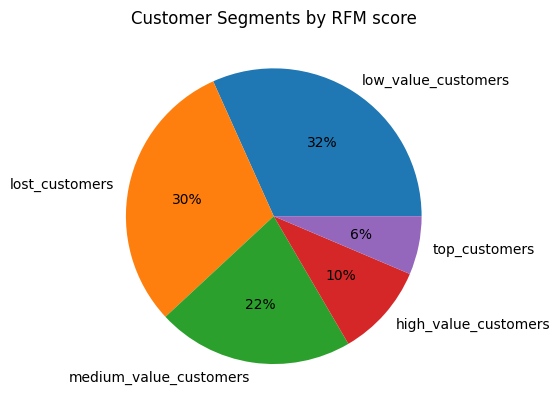

In [73]:
# Display distribution of customer segments for RFM score rankings
plt.pie(
    rfm_df["customer_segment"].value_counts(),
    labels=rfm_df["customer_segment"].value_counts().index,
    autopct="%.0f%%",
)
plt.title("Customer Segments by RFM score")
plt.show()

Now we will add the RFM calculated `customer_segment` variable to our main dataframe.

In [74]:
# Subset rfm_df to the desired columns
rfm_df = rfm_df[["customer_id", "customer_segment"]]

# Merge on 'customer_id' column
retail_data = retail_data.merge(rfm_df, on="customer_id", how="left")
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue,month,customer_segment
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567,December,medium_value_customers
1,489434,79323P,PINK CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December,medium_value_customers
2,489434,79323W,WHITE CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December,medium_value_customers
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,medium_price,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010,December,medium_value_customers
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987,December,medium_value_customers


In [75]:
na_vals_joined = retail_data["customer_segment"].isna().sum()
shape_joined = retail_data.shape
print(f"The shape of the data after joining is: {na_vals_joined}.")
print(f"The column customer_segments has {na_vals_joined} missing values.")

The shape of the data after joining is: 0.
The column customer_segments has 0 missing values.


## Topic Modeling `description` with Top2Vec vs LDA (gensim) 
---

#### Top2Vec

In [76]:
# Let's determine the total number of documents in our corpus along with
unique_descriptions = retail_data["description"].nunique()
avg_doc_len = np.mean(
    [len(d.split()) for d in retail_data["description"].unique().tolist()]
).round()
print(f"There are {unique_descriptions} unique descriptions in out dataset.")
print(f"Each description has an average of {avg_doc_len} words.")

There are 5355 unique descriptions in out dataset.
Each description has an average of 4.0 words.


Our data now has more categorical features. One issue we may face in the future is our `description` variable having so many unique descriptions (5355). With all of these descriptions it will be very difficult to make any meaningful model unless we categorize them. We will first try do this with Topic Modeling via the *Top2Vec* library. I do have some doubts though just because there are only 5355 descriptions, each with an average of ~4 words. It will definitely be difficult to generalize.

In [77]:
# Create list of descriptions
descriptions_text = retail_data["description"].unique().tolist()
unique_docs = [preprocess_text(text) for text in descriptions_text]

In [78]:
unique_docs

[' christmas glass ball  lights',
 'pink cherry lights',
 ' white cherry lights',
 'record frame  single size ',
 'strawberry ceramic trinket box',
 'pink doughnut trinket pot ',
 'save the planet mug',
 'fancy font home sweet home doormat',
 'cat bowl ',
 'dog bowl  chasing ball design',
 'heart measuring spoons large',
 'lunchbox with cutlery fairy cakes ',
 'door mat black flock ',
 'love building block word',
 'home building block word',
 'assorted colour bird ornament',
 ' peace wooden block letters',
 'christmas craft white fairy ',
 'heart ivory trellis large',
 'heart filigree dove large',
 'full english breakfast plate',
 'pizza plate in box',
 'black diner wall clock',
 'set of  black flying ducks',
 'area patrolled metal sign',
 'please one person metal sign',
 'bath building block word',
 'classic white frame',
 'small marshmallows pink bowl',
 'biscuits small bowl light blue',
 'scottie dog hot water bottle',
 'christmas craft heart decorations',
 'christmas craft heart st

In [79]:
# #Instantiate/train Top2Vec model
# model = Top2Vec(unique_docs)

# # Save model
# model.save(
#     r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\models\t2v_mod"
# )

In [80]:
# Load in model trained on all documents
model = Top2Vec.load(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\models\t2v_mod"
)

In [81]:
# Grab the size and number of all of our topics
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

[289 284 277 268 268 265 263 259 258 257 255 253 250 248 248 244 240 236
 234 231 228]


`topic_sizes` shows us the amount of documents that correspond to each topic where each index in this list is an individual topic ordered from topics with the most documents to fewest documents at the end of the list.

In [82]:
print(topic_nums)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


`topic_nums` simply displays the index numbers sequentially. Here, we can see that we have 21 unique topics in our model.

In [83]:
# Rank top 5 topics on most common to least common basis
topic_words, word_scores, topic_nums = model.get_topics(5)

In [84]:
# Iterate over these three outputs
for words, scores, num in zip(topic_words, word_scores, topic_nums):
    print(num)
    print(f"Words: {words}")

0
Words: ['mug' 'christmas' 'hook' 'retro' 'and' 'necklace' 'spotty' 'frame' 'bird'
 'butterfly' 'holder' 'easter' 'design' 'clock' 'tree' 'ceramic' 'flower'
 'cream' 'large' 'bowl' 'earrings' 'cutlery' 'bag' 'card' 'box' 'tlight'
 'assorted' 'candle' 'home' 'door' 'rose' 'with' 'hanging' 'party' 'fairy'
 'set' 'wrap' 'wooden' 'tin' 'gold' 'bracelet' 'blue' 'tile' 'mini' 'of'
 'star' 'love' 'pack' 'mirror' 'photo']
1
Words: ['polkadot' 'small' 'vintage' 'candles' 'spotty' 'design' 'paper' 'green'
 'ceramic' 'black' 'frame' 'clock' 'cushion' 'girl' 'and' 'in' 'home'
 'star' 'tile' 'card' 'cream' 'ring' 'easter' 'blue' 'cake' 'fairy'
 'round' 'hook' 'gold' 'pink' 'white' 'wrap' 'hanging' 'french' 'flower'
 'retro' 'sign' 'love' 'butterfly' 'cutlery' 'photo' 'silver' 'zinc'
 'wall' 'art' 'spot' 'bowl' 'mini' 'mug' 'bag']
2
Words: ['love' 'home' 'bird' 'spot' 'cover' 'round' 'ivory' 'of' 'green' 'tile'
 'assorted' 'necklace' 'retro' 'set' 'hook' 'tea' 'door' 'zinc'
 'butterfly' 'cutlery' '

Let's just look at topic one right now. We are going to look at topic one and the top 3 documents that most correspond to it.

In [85]:
# Grab corresponding top 10 documents for topic one
documents, document_scores, document_ids = model.search_documents_by_topic(
    topic_num=0, num_docs=3
)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("--------------")
    print(doc)
    print("--------------")
    print()

Document: 3198, Score: 0.24041083455085754
--------------
flag of st george chair
--------------

Document: 3586, Score: 0.22752809524536133
--------------
magic drawing slate fido
--------------

Document: 4336, Score: 0.22522872686386108
--------------
polkadot coffee cup  saucer pink
--------------



These cosine similarities are very low and indicate weak or no similarity between our documents and the topics we classified. This is really no surprise since we have such few documents (<6000) with the average length of 4 words per document.  

However, the main metric that topic models tend to use is the CV Coherence score - a measure used to evaluate the quality of topics generated by a topic modeling algorithm. It asseses how well the words within a topic are related and how distinct different topics are from each other (the higher the score, the more coherent the topics). Analytically, this is the normalized NPMI (Normalized Pointwise Mutual Information) and cosine similarity.  

$$
C_V = \frac{\sum_{i < j} \text{score}(w_i, w_j)}{\sum_{i < j} \text{normalization}(w_i, w_j)}
$$

Here, $w_i$ and $w_j$ are words, and the function $text{score}(w_i, w_j)$ and $text{normalization}(w_i, w_j)$ contribute to the score and normalization, respectively. The summations are over all pairs of words $i$ and $j$ $(i < j)$ in the set of top words for each topic.  

The specific formulas for $text{score}(w_i, w_j)$ uses cosine similarity:

$$
\text{Cosine Similarity} = \frac{{w_i \cdot w_j}}{{\|w_i\| \cdot \|w_j\|}}
$$

In [86]:
# Compute the NPMI (Normalized Pointwise Mutual Information) Coherence Score for Top2Vec
compute_cv_coherence(model, unique_docs)

0.0

Using my handcrafted formula for Coherence CV score (see `top2vec_utils.py`) indicates that our score is ~0 and there is little to no semantic coherence among the top words in the topics genreated by our Top2Vec topic model. This could be because of a number of reasons but is probably mainly due to a short corpus size and how Top2Vec is configured.

#### LDA (gensim)

To get a variety of topic modeling outputs, we are also going to test gensim's LDA model on our descriptions.

In [87]:
# Create list of Stop words using NLTK
stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use", "cm", "ft"])

In [88]:
# Tokenize each sentence into a list of words using simple_preprocess (see gensim_lda.py)
data_words = list(sent_to_words(unique_docs))
print(data_words[:1])

[['christmas', 'glass', 'ball', 'lights']]


In [89]:
# Create bigram and trigram models using gensim's Phrases model
bigram = Phrases(data_words, min_count=1, threshold=2)
trigram = Phrases(bigram[data_words], threshold=2)

# Use the 'Phraser' class from gensim to apply bigram/trigram models in memory-effieicent way
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['christmas', 'glass_ball', 'lights']


In [90]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words, stop_words=stop_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod=bigram_mod)

# Initialize spacy 'en_core_web_lg' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, nlp=nlp)

In [91]:
# Preview the first three elements of data_lemmatized
print(data_lemmatized[:3])

[['light'], ['pink', 'cherry_light'], ['white_cherry', 'light']]


The two main inputs to the gensim LDA topic model are the dictionary (id2word) and the corpus. Let's create them.

In [92]:
# Create a dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[(0, 1)], [(1, 1), (2, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).  For example, (0,1) above implies that word id 0 occurs once in the first document, word id 1 occurs once as well. Since our documents are so shorty, each element of corpus will only contain a few (word_id, word_frequency) tuples.

<u>Building the Topic Model</u>

  Parameters: `alpha` and `eta` - hyperparameters that affect the sparsity of the topics. `chunksize` - the number of documents to be used in each training chunk. `update_every` - determines how often the model parameters should be updated. `passes` is the total number of training passes.

In [93]:
# Build LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=42,
    update_every=1,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. We will now look at the weightage (importance) of each keyword using `lda_model.print_topics()` 

In [94]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.043*"small" + 0.041*"glass" + 0.040*"rise" + 0.030*"vintage_christma" + 0.020*"pink_polkadot" + 0.019*"kit" + 0.018*"sticker" + 0.018*"key_ring" + 0.018*"letter_ble" + 0.015*"butterfly"'), (1, '0.235*"set" + 0.036*"black" + 0.028*"star" + 0.024*"polkadot" + 0.022*"tin" + 0.019*"tlight" + 0.016*"candle" + 0.015*"fairy_cake" + 0.014*"paper_lantern" + 0.011*"spaceboy"'), (2, '0.103*"large" + 0.042*"bottle" + 0.034*"necklace" + 0.026*"bag" + 0.023*"hot_water" + 0.021*"tea" + 0.020*"cake" + 0.015*"assort" + 0.015*"ribbon_reel" + 0.011*"small"'), (3, '0.063*"pack" + 0.036*"pink" + 0.034*"box" + 0.027*"bowl" + 0.024*"tissue" + 0.021*"stand" + 0.021*"colour" + 0.016*"purse" + 0.016*"chocolate" + 0.015*"small"'), (4, '0.069*"design" + 0.052*"green" + 0.045*"set_card" + 0.040*"wrap" + 0.038*"mug" + 0.032*"dolly_girl" + 0.028*"gold" + 0.020*"home" + 0.019*"wall_art" + 0.011*"charm"'), (5, '0.101*"blue" + 0.069*"vintage" + 0.044*"candle" + 0.031*"hang" + 0.027*"decoration" + 0.026*"plate" 

Compute Model Perplexity and Coherence Score  
Model preplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [95]:
# Compute Perplexity
print(
    f"Perplexity: {lda_model.log_perplexity(corpus)}"
)  # A measure of how good the model is - the lower the  better

# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"\nCoherence Score: {coherence_lda}")

Perplexity: -7.948803081569466

Coherence Score: 0.6877782822933411


Here, we get a coherence score of ~0.69 when using 10 topics.  

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. We will use pyLDAvis package's interactive chart. 

In [96]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.341680 -0.052645       1        1  13.441963
8     -0.128984 -0.161849       2        1  11.843979
5      0.037503 -0.124350       3        1  11.370284
7     -0.074430 -0.047589       4        1  10.579720
9     -0.005800  0.233909       5        1  10.520270
0     -0.045402  0.056865       6        1   9.638704
3     -0.063367 -0.066694       7        1   8.563924
4     -0.011312  0.129608       8        1   8.481580
2     -0.022957  0.073859       9        1   8.053668
6     -0.026932 -0.041114      10        1   7.505908, topic_info=           Term        Freq       Total Category  logprob  loglift
42          set  334.000000  334.000000  Default  30.0000  30.0000
2          pink  222.000000  222.000000  Default  29.0000  29.0000
30        heart  124.000000  124.000000  Default  28.0000  28.0000
55         blue  121.000000  121.000000  Default  27.0000  27.0000
14        large   88.000000   88.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
180        mini   10.722050   18.426819  Topic10  -4.3049   2.0480
318       paint    6.917376   11.755197  Topic10  -4.7432   2.0592
86       holder    9.271567   42.137813  Topic10  -4.4503   1.0755
463       metal    7.206382   35.116310  Topic10  -4.7023   1.0058
61   decoration    7.270690   62.062435  Topic10  -4.6934   0.4452

[391 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
2214      9  0.937066  acrylic_edwardian
1335     10  0.932543      acrylic_jewel
1365      1  0.969504        alarm_clock
303       8  0.851379           alphabet
1593      5  0.835927              amber
...     ...       ...                ...
2283      8  0.915748       wrap_vintage
69        6  0.935849             wreath
341       4  0.917169             yellow
464       2  0.229231               zinc
464       4  0.687693               zinc

[400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 6, 8, 10, 1, 4, 5, 3, 7])

<u>How to infer pyLDAvis's output</u>  

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent the topic. Ideally, a good topic model will have fairly large, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.  

A model that has too many topics will typically have many overlaps, small sized bubbles clustered in one region of the chart.


<u>Finding the optimal number of topics for LDA</u>  

Next, we will find the optimal number of topics by building many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.   

Choosing a k value that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value cna sometimes provide more granular subtopics. If we see repeated keywords in multiple topics, it probably means our k is too large.  

We will create a `compute_coherence_values()` function that trains multiple LDA models and provides the models and their corresponding coherence scores.

In [97]:
# This might take a long time to run...
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=data_lemmatized,
    start=1,
    limit=40,
    id2word=id2word,
    step=1,
)

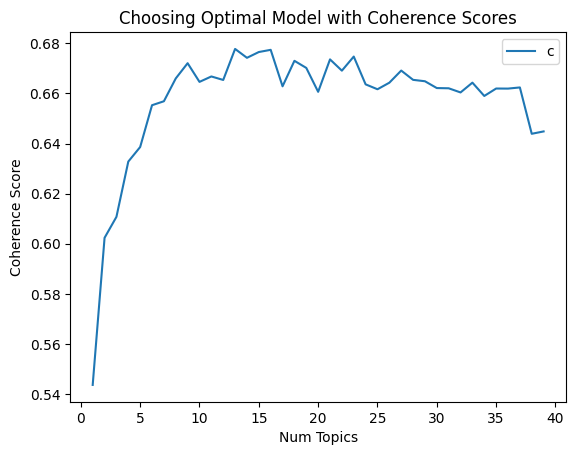

In [98]:
# Show graph
limit = 40
start = 1
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.title("Choosing Optimal Model with Coherence Scores")
plt.show()

In [99]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.5436
Num Topics = 2  has Coherence Value of 0.6024
Num Topics = 3  has Coherence Value of 0.6107
Num Topics = 4  has Coherence Value of 0.6328
Num Topics = 5  has Coherence Value of 0.6386
Num Topics = 6  has Coherence Value of 0.6553
Num Topics = 7  has Coherence Value of 0.6569
Num Topics = 8  has Coherence Value of 0.666
Num Topics = 9  has Coherence Value of 0.6721
Num Topics = 10  has Coherence Value of 0.6646
Num Topics = 11  has Coherence Value of 0.6668
Num Topics = 12  has Coherence Value of 0.6654
Num Topics = 13  has Coherence Value of 0.6778
Num Topics = 14  has Coherence Value of 0.6742
Num Topics = 15  has Coherence Value of 0.6765
Num Topics = 16  has Coherence Value of 0.6774
Num Topics = 17  has Coherence Value of 0.6628
Num Topics = 18  has Coherence Value of 0.673
Num Topics = 19  has Coherence Value of 0.6702
Num Topics = 20  has Coherence Value of 0.6606
Num Topics = 21  has Coherence Value of 0.6736
Num Topics = 22  has Coh

Because the delta of coherence value at 6 topics is the largest, we are going to use 6 topics. Even though we can see up to a 0.2 gain in coherence from higher topic counts, there is no need to complicate our clustering algorithm/ time series forecasting model in the future for such a marginal gain. 

In [100]:
# Select the optimal model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=30))

[(0, '0.035*"set" + 0.027*"retrospot" + 0.025*"small" + 0.023*"polkadot" + 0.021*"rise" + 0.019*"pantry" + 0.016*"cream" + 0.016*"pink" + 0.015*"flower" + 0.015*"pink_polkadot" + 0.010*"mirror" + 0.009*"sticker" + 0.009*"design" + 0.008*"kit" + 0.007*"pen" + 0.007*"ribbon_reel" + 0.007*"bird" + 0.007*"garden" + 0.006*"wood" + 0.006*"playing_card" + 0.006*"blue" + 0.006*"yellow" + 0.006*"red" + 0.006*"lace" + 0.006*"wreath" + 0.006*"flower_fairy" + 0.006*"sweetheart" + 0.005*"dog" + 0.005*"heart" + 0.005*"flock"'), (1, '0.125*"set" + 0.023*"decoration" + 0.021*"star" + 0.014*"black" + 0.012*"tlight" + 0.011*"cottage_garden" + 0.011*"paper_lantern" + 0.010*"jar" + 0.008*"key_ring" + 0.008*"letter_ble" + 0.008*"candle" + 0.007*"container" + 0.007*"vintage_christma" + 0.006*"magnet" + 0.006*"rabbit" + 0.006*"napkin" + 0.006*"colour" + 0.006*"fairy_cake" + 0.006*"tin" + 0.005*"wall_clock" + 0.005*"birthday" + 0.005*"set_card" + 0.005*"egg_frye" + 0.005*"paper_doilie" + 0.005*"girl" + 0.005*

In [101]:
# Visualize the topics in the optimal lda model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.061212  0.118131       1        1  18.973840
1     -0.213635 -0.008119       2        1  17.138806
3      0.060550 -0.001689       3        1  16.382221
2      0.136559  0.027952       4        1  16.306820
0     -0.076768  0.076329       5        1  16.167346
4      0.032081 -0.212604       6        1  15.030967, topic_info=               Term        Freq       Total Category  logprob  loglift
42              set  332.000000  332.000000  Default  30.0000  30.0000
14            large   95.000000   95.000000  Default  29.0000  29.0000
91          vintage   93.000000   93.000000  Default  28.0000  28.0000
101             red  102.000000  102.000000  Default  27.0000  27.0000
1130      retrospot   47.000000   47.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
232          basket    8.874324   18.353740   Topic6  -5.1885   1.1684
1969    love_london    7.288925   13.178570   Topic6  -5.3853   1.3028
270   candle_holder    6.212246   10.115018   Topic6  -5.5451   1.4076
2              pink   13.914766  202.104423   Topic6  -4.7387  -0.7808
30            heart   10.567370  137.251321   Topic6  -5.0139  -0.6690

[326 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1335      5  0.896095  acrylic_jewel
1365      6  0.917467    alarm_clock
303       3  0.931386       alphabet
569       6  0.919002         animal
230       3  0.902568        antique
...     ...       ...            ...
464       1  0.213301           zinc
464       2  0.053325           zinc
464       3  0.639904           zinc
464       4  0.053325           zinc
2506      1  0.728243  zinc_watering

[549 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 4, 3, 1, 5])

This looks much better than our original LDA topic visualization. Now, none of our clusters overlap which means that the LDA algorithm did a much better job at generalizing than our initial model of 10 clusters, creating distinct clusters that will hopefully be easier to differentiate when we look at lists of common words near the centroid of each cluster.  

Now, we need to determine what topic a given document is about. To do this, we find the topic number that has the highest percentage contribution in that document. The `format_topics_sentences()` function nicely aggregates this information in a presentable table.

In [102]:
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=unique_docs
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.5832,"pink, red, pack, tissue, gold, light, box, sta...",christmas glass ball lights
1,1,3,0.7208,"pink, red, pack, tissue, gold, light, box, sta...",pink cherry lights
2,2,3,0.7221,"pink, red, pack, tissue, gold, light, box, sta...",white cherry lights
3,3,0,0.7915,"set, retrospot, small, polkadot, rise, pantry,...",record frame single size
4,4,5,0.5824,"vintage, blue, heart, candle, card, holder, wh...",strawberry ceramic trinket box
5,5,2,0.7199,"large, heart, sign, bottle, pink, french_blue,...",pink doughnut trinket pot
6,6,4,0.7915,"design, wrap, dolly_girl, green, mug, hook, ho...",save the planet mug
7,7,0,0.1667,"set, retrospot, small, polkadot, rise, pantry,...",fancy font home sweet home doormat
8,8,0,0.1667,"set, retrospot, small, polkadot, rise, pantry,...",cat bowl
9,9,4,0.5828,"design, wrap, dolly_girl, green, mug, hook, ho...",dog bowl chasing ball design


This on its own is still pretty difficult to interpret (topic keywords may not be enough to make sense of what the topic is about) So, to help with understanding the topic, we can find the documents a given topic has contributed to the most and infer the ropic by reading that document. 

In [103]:
# Group the top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_grouped = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in sent_topics_grouped:
    sent_topics_sorted = pd.concat(
        [
            sent_topics_sorted,
            grp.sort_values(["Perc_Contribution"], ascending=[0]).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ["Topic_Num", "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.8608,"set, retrospot, small, polkadot, rise, pantry,...",yellow flowers felt handbag kit
1,1,0.8607,"set, decoration, star, black, tlight, cottage_...",set black glitter reindeer candle
2,2,0.8608,"large, heart, sign, bottle, pink, french_blue,...",lets go shopping cotton tote bag
3,3,0.8608,"pink, red, pack, tissue, gold, light, box, sta...",pink ballet opening cube box
4,4,0.8610,"design, wrap, dolly_girl, green, mug, hook, ho...",magic sheep wool growing from paper
5,5,0.8800,"vintage, blue, heart, candle, card, holder, wh...",blue cat biscuit barrel pink heart


In [104]:
for idx, kw in enumerate(sent_topics_sorted.Keywords):
    print(idx, kw)
    print("---")

0 set, retrospot, small, polkadot, rise, pantry, cream, pink, flower, pink_polkadot
---
1 set, decoration, star, black, tlight, cottage_garden, paper_lantern, jar, key_ring, letter_ble
---
2 large, heart, sign, bottle, pink, french_blue, metal_door, necklace, flower, bag
---
3 pink, red, pack, tissue, gold, light, box, stand, tin, chocolate
---
4 design, wrap, dolly_girl, green, mug, hook, home, bunny, tree, set_card
---
5 vintage, blue, heart, candle, card, holder, white, pink, set, plate
---


### Rationale for Classifications

**Topic 0: Home and Kitchen Decor with Retro and Floral Themes**  

- <u>Top Keywords</u>:  
"set," "retrospot," "small," "polkadot," "rise," "pantry," "cream," "pink," "flower," "pink_polkadot" suggest that the topic is related to home and kitchen decor or accessories with a focus on retro and floral designs.
- <u>Best Text Example</u>:  
"Yellow flowers felt handbag kit" aligns with the top keywords, indicating items related to retro and floral-themed accessories or craft kits.

**Topic 1: Decorative Items with a Focus on Candles and Garden Themes**  

- <u>Top Keywords</u>:  
"set," "decoration," "star," "black," "tlight," "cottage_garden," "paper_lantern," "jar," "key_ring," "letter_ble" suggest that the topic is related to decorative items, especially those related to stars, candles, and garden themes.
- <u>Best Text Example</u>:
"Set black glitter reindeer candle" aligns with the top keywords, indicating products related to decorative items, specifically candles with a black glitter reindeer theme.

**Topic 2: Accessories and Bags**  

- <u>Top Keywords</u>:  
"large," "heart," "sign," "bottle," "pink," "french_blue," "metal_door," "necklace," "flower," "bag" suggest that the topic may be related to various accessories and items, including bags, jewelry, and decorative products, with a focus on colors like pink and French blue.
- <u>Best Text Example</u>:  
"Lets go shopping cotton tote bag" aligns with the top keywords, indicating a product related to tote bags for shopping.

**Topic 3: Gift Packaging and Presentation**  
- <u>Top Keywords</u>:  
"pink," "red," "pack," "tissue," "gold," "light," "box," "stand," "tin," "chocolate" suggest that the topic may be related to packaging and presentation of gifts or items, featuring a color palette including pink, red, gold, and possibly containing light elements.  

- <u>Best Text Example</u>:  
"Pink ballet opening cube box" aligns with the top keywords, indicating a product related to decorative gift boxes for special occasions.

**Topic 4: Creative Home Decor and Aesthetic Designs**  
- <u>Top Keywords</u>:  
"design," "wrap," "dolly_girl," "green," "mug," "hook," "home," "bunny," "tree," "set_card" suggest that the topic may involve creative and decorative items with a focus on design and aesthetics, including products related to home decor and possibly featuring a dolly girl motif.  

- <u>Best Text Example</u>:  
"Magic sheep wool growing from paper" doesn't directly align with the top keywords, but it hints at whimsical or creative products.

**Topic 5: Vintage-Inspired Home Decor**  
- <u>Top Keywords</u>:  
"vintage," "blue," "heart," "candle," "card," "holder," "white," "pink," "set," "plate" suggest that the topic is likely centered around vintage-themed or nostalgic household items, including products like candle holders, cards, and plates, with a focus on aesthetics and design.  

- <u>Best Text Example</u>:  
"Blue cat biscuit barrel pink heart" aligns with the top keywords, indicating items related to vintage or nostalgic themes, possibly including decorative household products with unique designs.



In [105]:
# Now that we have our categories, let's map them to our descriptions.
categories = {
    0: "Home and Kitchen Decor with Retro and Floral Themes",
    1: "Decorative Items with a Focus on Candles and Garden Themes",
    2: "Accessories and Bags",
    3: "Gift Packaging and Presentation",
    4: "Creative Home Decor and Aesthetic Designs",
    5: "Vintage-Inspired Home Decor"
}

# Get the document-topic distribution
all_topics = optimal_model.get_document_topics(corpus, minimum_probability=0.0)

# Convert the distribution to a DataFrame
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)


# Display the DataFrame
all_topics_df["descriptions"] = retail_data["description"].unique().tolist()

# Create a new column with the maximum value and the corresponding column name
all_topics_df["topic"] = all_topics_df.iloc[:, :-1].apply(
    lambda row: row.idxmax(), axis=1
)
all_topics_df["topic"] = all_topics_df["topic"].map(categories)

# Create a dictioanry to map 'descriptions' to keys and 'topic' to values
topic_to_description = all_topics_df.set_index("descriptions")["topic"].to_dict()

In [106]:
topic_to_description

{'15CM CHRISTMAS GLASS BALL 20 LIGHTS': 'Gift Packaging and Presentation',
 'PINK CHERRY LIGHTS': 'Gift Packaging and Presentation',
 ' WHITE CHERRY LIGHTS': 'Gift Packaging and Presentation',
 'RECORD FRAME 7" SINGLE SIZE ': 'Home and Kitchen Decor with Retro and Floral Themes',
 'STRAWBERRY CERAMIC TRINKET BOX': 'Vintage-Inspired Home Decor',
 'PINK DOUGHNUT TRINKET POT ': 'Accessories and Bags',
 'SAVE THE PLANET MUG': 'Creative Home Decor and Aesthetic Designs',
 'FANCY FONT HOME SWEET HOME DOORMAT': 'Home and Kitchen Decor with Retro and Floral Themes',
 'CAT BOWL ': 'Home and Kitchen Decor with Retro and Floral Themes',
 'DOG BOWL , CHASING BALL DESIGN': 'Creative Home Decor and Aesthetic Designs',
 'HEART MEASURING SPOONS LARGE': 'Accessories and Bags',
 'LUNCHBOX WITH CUTLERY FAIRY CAKES ': 'Accessories and Bags',
 'DOOR MAT BLACK FLOCK ': 'Gift Packaging and Presentation',
 'LOVE BUILDING BLOCK WORD': 'Gift Packaging and Presentation',
 'HOME BUILDING BLOCK WORD': 'Creative Ho

In [107]:
all_topics_df.head()

,0,1,2,3,4,5,descriptions,topic
0,0.083412,0.083348,0.083334,0.583155,0.083398,0.083352,15CM CHRISTMAS GLASS BALL 20 LIGHTS,Gift Packaging and Presentation
1,0.056055,0.055616,0.056082,0.720850,0.055663,0.055734,PINK CHERRY LIGHTS,Gift Packaging and Presentation
2,0.055585,0.055568,0.055564,0.722132,0.055582,0.055569,WHITE CHERRY LIGHTS,Gift Packaging and Presentation
3,0.791517,0.041695,0.041696,0.041696,0.041696,0.041701,"RECORD FRAME 7"" SINGLE SIZE",Home and Kitchen Decor with Retro and Floral T...
4,0.083528,0.083526,0.083529,0.083530,0.083530,0.582356,STRAWBERRY CERAMIC TRINKET BOX,Vintage-Inspired Home Decor


In [108]:
# Map the topics to descriptions in the main dataframe
retail_data["topic"] = retail_data["description"].map(topic_to_description)

In [109]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue,month,customer_segment,topic
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567,December,medium_value_customers,Gift Packaging and Presentation
1,489434,79323P,PINK CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December,medium_value_customers,Gift Packaging and Presentation
2,489434,79323W,WHITE CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December,medium_value_customers,Gift Packaging and Presentation
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,medium_price,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010,December,medium_value_customers,Home and Kitchen Decor with Retro and Floral T...
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987,December,medium_value_customers,Vintage-Inspired Home Decor


In [110]:
# Make sure there are no null values for topic
retail_data["topic"].isna().sum()

0

Because we have no na values for the `topic` column, this means we have successfully mapped all topics to our descriptions for our entire retail dataset.

## Exploratory Data Analysis (EDA)
---


To begin EDA, I am going to perform a univartiate analysis on variables that might give me more information on specific demographics. 

### Analyzing the Frequency of Transactions per month.


In [111]:
# Count the number of orders for each month
# unique_month_counts =  retail_data.groupby("month")["customer_id"].nunique().sort_values(ascending=False)
month_counts = retail_data["month"].value_counts()
print(month_counts)

month
November     145579
October      104389
December     103205
September     80672
March         69342
June          67583
July          64143
May           63026
August        59812
January       58893
April         57175
February      50345
Name: count, dtype: int64


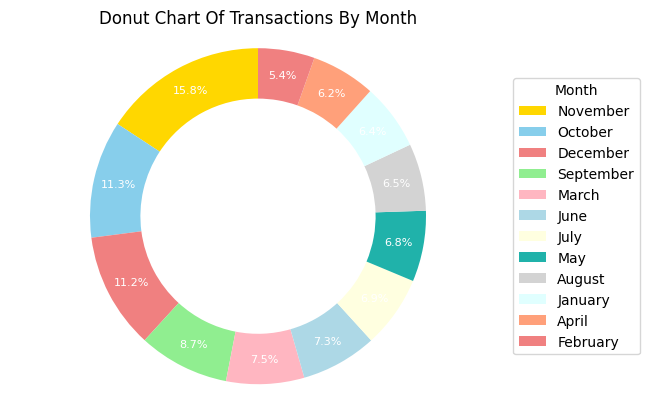

In [112]:
# Plot donut chart illustrating transaction distribution by month
plot_donut_chart(
    month_counts,
    title="Donut Chart of Transactions by Month",
    legend="month",
    threshold=41,
)

According to out dataset, the highest volume of transactions occurs in the months November, October, and December. I think this makes sense because the U.K.-based store we are analyzing sells gifts and the majority of gift giving holidays occur at the end of the year.

### Analyzing the Distribution of Topics

In [113]:
# Count number of orders for each topic
topic_counts = retail_data["topic"].value_counts()
print(topic_counts)

topic
Home and Kitchen Decor with Retro and Floral Themes           259873
Decorative Items with a Focus on Candles and Garden Themes    140447
Accessories and Bags                                          136410
Vintage-Inspired Home Decor                                   133638
Gift Packaging and Presentation                               133629
Creative Home Decor and Aesthetic Designs                     120167
Name: count, dtype: int64


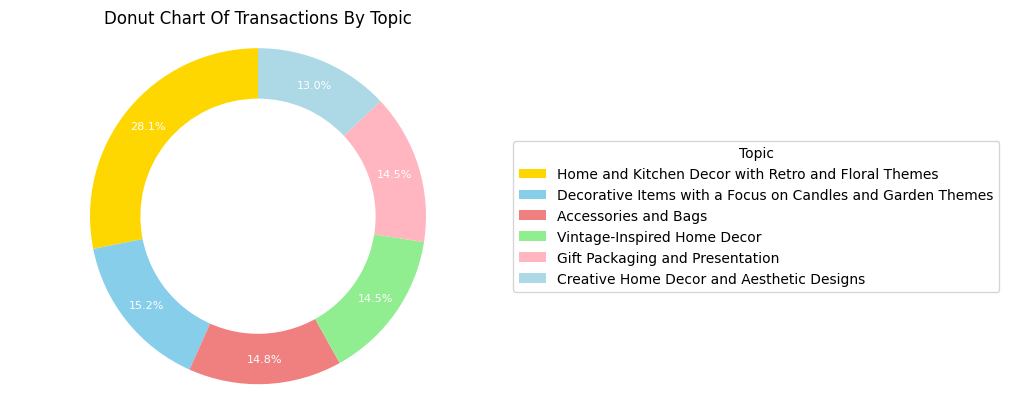

In [114]:
# Plot donut chart analyzing how often each topic category was purchased
plot_donut_chart(
    topic_counts, title="Donut Chart of Transactions by Topic", legend="topic"
)

This donut chart shows us that the most commonly purchasesd item categories from the U.K. store are "Home and Kitchen Decor with Retro and Floral Themes", ""Decorative Items with a Focus on Candles and Garden Themes", and "Accessories and Bags".

### Analyzing Diustribution of Quantities Purchased 

In [115]:
# Count number of orders for each quantity cateogry
quantity_counts = retail_data["quantity"].value_counts()
print(quantity_counts)

quantity
low_quantity       552531
high_quantity      211692
medium_quantity    159941
Name: count, dtype: int64


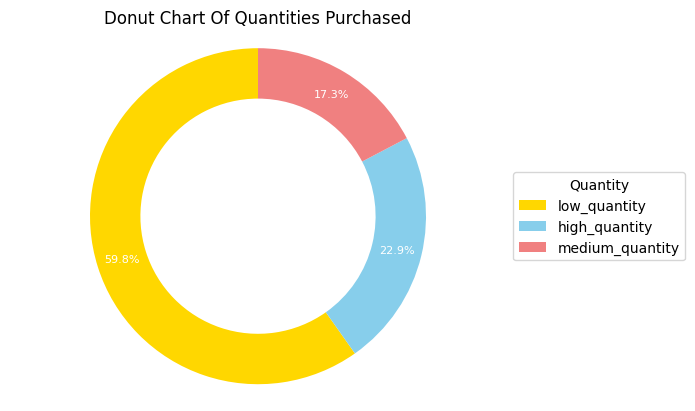

In [116]:
# Plot donut chart analyzing the distriubtion of quantity categories we defined
plot_donut_chart(
    quantity_counts,
    title="Donut Chart of Quantities Purchased",
    legend="quantity",
)

This donut chart shows us that customers most commonly buy low quantities, medium quantities, and high quantities of gifts, in that order. To break down the proportions more analytically:

- 59.8% of purchases were a low quantity (1-4 items).
- 17.3% of purchases were a medium quantity (4-12 items).
- 22.9% of purchases were a high quantity (12-80994.79 items).


### Analyzing Diustribution of Prices sold

In [117]:
# Count number of orders for each price cateogry
price_counts = retail_data["price"].value_counts()
print(price_counts)

price
low_price         261557
medium_price      252662
high_price        225002
very_low_price    184943
Name: count, dtype: int64


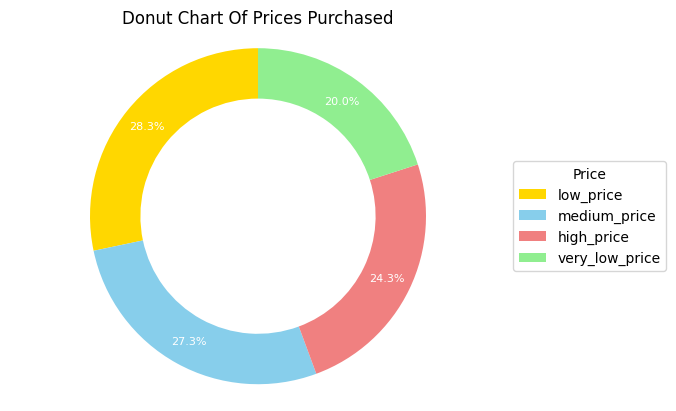

In [118]:
# Plot donut chart analyzing the distriubtion of price categories we defined
plot_donut_chart(
    price_counts,
    title="Donut Chart of Prices Purchased",
    legend="price",
)

Here, this donut chart illustrates that customers most commonly tend to buy very low price items, low price items, high price items, low price items, and medium price items, in that order. To break down these categories analytically:

- 20.0% of the purchases were very low priced (0£-1.25£) items.
- 24.3% of the purchases were high priced (4.13£-1157.14£) items.
- 28.3% of the purchases were low priced (1.25£-2.10£) items.
- 27.3% of the purchases were medium priced (2.10£-4.13£) items.

## Customer Segmentation using K-Modes Clustering
---

While the traditional K-Means clustring algorithm does a great job with continuous numeric data, it does not work well for variable data which is the format I would like to use. I think it will be easier to intuitively categorize customer clusters by combinations of categories (i.e. 'medium price, high quantity, U.K., and 'Home Decor/Accessores'). Fortunately, there is an approach well-tailored for this task called "K-Modes clustering".

K-Modes (proposed by Huang, Z in 1997) uses a measure of dissimilarity for categorical objects and iterates over clusters, choosing new modes each time with the aim of minimizing the measure of dissimilarity. Just like any other clustering approach, I need to decide when to stop with segmenting the data into clusters, choosing an optimal number of clusters. The best way to do this is by evaluating an Elbow Plot.

In [119]:
# Create a relevant subset of retail_data that you want to cluster on
cluster_input = retail_data[["quantity", "price", "topic", "customer_segment"]]

Here, we do not cluster by month because then we would have limited historical data to build a time series forecasting model with.

In [120]:
cluster_input.head()

,quantity,price,topic,customer_segment
0,high_quantity,high_price,Gift Packaging and Presentation,medium_value_customers
1,high_quantity,high_price,Gift Packaging and Presentation,medium_value_customers
2,high_quantity,high_price,Gift Packaging and Presentation,medium_value_customers
3,high_quantity,medium_price,Home and Kitchen Decor with Retro and Floral T...,medium_value_customers
4,high_quantity,low_price,Vintage-Inspired Home Decor,medium_value_customers


In [121]:
cluster_input.isna().sum()

quantity            0
price               0
topic               0
customer_segment    0
dtype: int64

KModes started at 2023-10-25 21:21:27.767868
Initialization method and algorithm are deterministic. Setting n_init to 1.


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2138430.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1888735.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1734109.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1613723.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1555087.0
Initialization method and algorithm are d

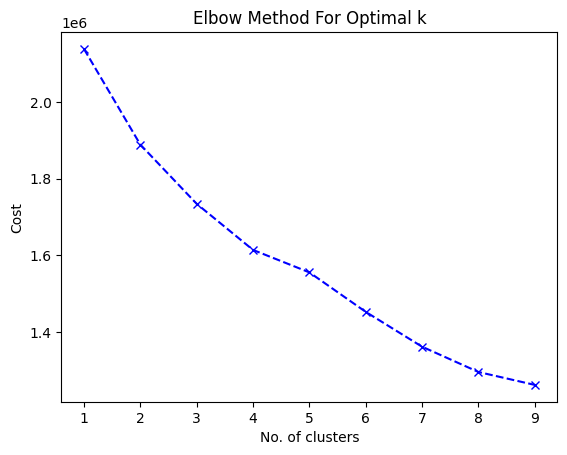

In [122]:
print(f"KModes started at {pd.Timestamp.now()}")

# Use an elbow curve to find the optimal k
cost = []
k = range(1, 10)
for num_clusters in list(k):
    kmode = KModes(n_clusters=num_clusters, n_init=5, verbose=1, random_state=42)
    kmode.fit_predict(cluster_input)
    cost.append(kmode.cost_)

print(f"Completed at {pd.Timestamp.now()}")

plt.plot(k, cost, "bx--")
plt.xlabel("No. of clusters")
plt.ylabel("Cost")
plt.title("Elbow Method For Optimal k")
plt.show()

The result of our Elbow Plot indicates that 4 clusters is a good number to go with. The pace of the decline in the cost metric slows significantly after 4 clusters.  

With 4 clusters decided, we will re-run the K-Modes clustering specifying 4 clusters.

In [123]:
# Fit optimal K-Modes model with 5 clusters
kmode_opt = KModes(n_clusters=4, n_init=5, verbose=1, random_state=42)
cluster_assignmnets = kmode_opt.fit_predict(cluster_input)
retail_data["cluster"] = cluster_assignmnets

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1613723.0


In [124]:
# Add cluster assignments back to the original dataframe
retail_data["cluster"] = cluster_assignmnets
cluster_input['cluster'] = cluster_assignmnets

C:\Users\evans\AppData\Local\Temp\ipykernel_25368\2969491169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_input['cluster'] = cluster_assignmnets


In [125]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue,month,customer_segment,topic,cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567,December,medium_value_customers,Gift Packaging and Presentation,3
1,489434,79323P,PINK CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December,medium_value_customers,Gift Packaging and Presentation,3
2,489434,79323W,WHITE CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December,medium_value_customers,Gift Packaging and Presentation,3
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,medium_price,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010,December,medium_value_customers,Home and Kitchen Decor with Retro and Floral T...,2
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987,December,medium_value_customers,Vintage-Inspired Home Decor,0


### Visualizing the Distribution of Our Clusters

In [126]:
# Count the number of orders for each cluster
cluster_counts = retail_data["cluster"].value_counts()
print(cluster_counts)

cluster
0    542267
1    163785
2    126266
3     91846
Name: count, dtype: int64


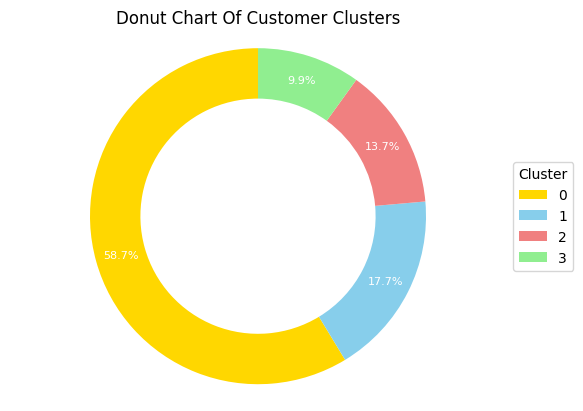

In [127]:
# Plot a donut chart visualizing the distribution of our 4 clusters
plot_donut_chart(
    cluster_counts,
    title="Donut Chart of Customer Clusters",
    legend="cluster",
)

In [128]:
kmode_opt.cluster_centroids_

array([['low_quantity', 'low_price',
        'Home and Kitchen Decor with Retro and Floral Themes',
        'top_customers'],
       ['low_quantity', 'medium_price',
        'Decorative Items with a Focus on Candles and Garden Themes',
        'high_value_customers'],
       ['high_quantity', 'medium_price', 'Accessories and Bags',
        'top_customers'],
       ['low_quantity', 'high_price', 'Accessories and Bags',
        'medium_value_customers']], dtype='<U58')

Of our four clusters, cluster 0 makes up the most of our transactions, followed by cluster 1, cluster 2, cluster 3, and cluster 4. Here is a more comprehensive breakdown of cluster demographics:

- **Cluster 0 ("Budget-Conscious Home Decor Shoppers")** : This segment of customers tends to buy a 'low quantity' of items (2-5 items) per transaction where category is 'Home and Kitchen Decor with Retro and Floral Themes', the price of the item purchased tends to be considered 'low price' (2.25£-3.10£), and the customer is classified as a 'top customer' (normalized RFM score > 4.5).

- **Cluster 1 ("Garden and Decor Enthusiasts")**: This segment of customers generally purchases a 'low quantity' of items (2-5 items) per transaction where the category is 'Decorative Items with a Focus on Candles and Garden Themes', the price of the item tends to be 'medium price' (3.10£-5.13£), and the customer is classified as a 'high value customer' (normalized RFM score between 4 and 4.5).

- **Cluster 2 ("Frequent Shopper/Top Customers")**: This segment of customers purchases a 'high quantity' of items (12-80994.79 items) per transaction where category is 'Accessories and Bags', the typical price of the items purchased tends to be 'medium price' (1.25£-2.10£), and the customer is classified as a 'top customer' (normalized RFM score > 4.5). 

- **Cluster 3 ("High-End Shoppers with Moderate Value")**: This segment of customers tends to buy a 'low quantity' of items (2-5 items) per transaction where category is 'Accessories and Bags', the price is classified as 'high price' (4.13£-1157.14£), and the customer is a 'medium value customer' (normalized RFM score between 3 and 4).





## Using ARIMA/SARIMA  for Time Series Forecasting
---

For this problem, we use forecasting in an attempt to provide this U.K. company with business insights so it can plan procurement and production activities. We will use ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) to tackle this problem, making the fundamental assumption that the information in the past values of our time series can alone be used to predict the future values of revenue.  

<u>ARIMA model</u>

ARIMA is a popular time series forecasting model that combines autoregressive (AR) and moving average (MA) components with differencing to handle non-stationary data. There are three components:  

1. **Autoregressive (AR)**: It models the linear relationship between the current observation and a number *p* of lagged observations. It captures the dependency of the current value on its past values.
1. **Moving Average (MA)**: It models the dependency of the current observation on a number *q* of residual errors from previous observations. It captures the short-term shocks or random fluctuations in the data.
1. **Integration (I)**: It accounts for the differencing required to make the time series stationary. Differencing involves subtracting the previous observation from the current observation to remove trends or seasonality. The order of differencing, denoted by *d*, represents the number of times differencing is applied to achieve stationarity.  

By combining these three components (AR, I, MA), the ARIMA model is capable of capturing the linear dependencies and trends in time series data. The order of the ARIMA model is typically represented as (*p*, *d*, *q*) where *p* represents the order of the AR component, *d* represents the order of differencing, and *q* represents the order of the MA component.   

<u>SARIMA model</u>  

Since our data most likely has seasonal components, we will use SARIMA which incorporates seasonal components to handle time series data with recurring patterns at fixed intervals, such as daily, weekly, or yearly cycles. SARIMA includes additional seasoal AR, MA, and I components in addition to the ones included in ATIMA. The order of the SARIMA model is typically denoted as (*p*, *d*, *q*)(*P*, *D*, *Q*, *m*) where lowercase parameters refer to non-seasonal components and uppercase represent seasonal componenets.


To get a general trend of seasonality's impact on revenue, we will look at a plot of average revenue vs. month.

c:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\notebooks\arima_utils.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_monthly_rev = retail_data.sort_values("month").groupby("month")["revenue"].mean()


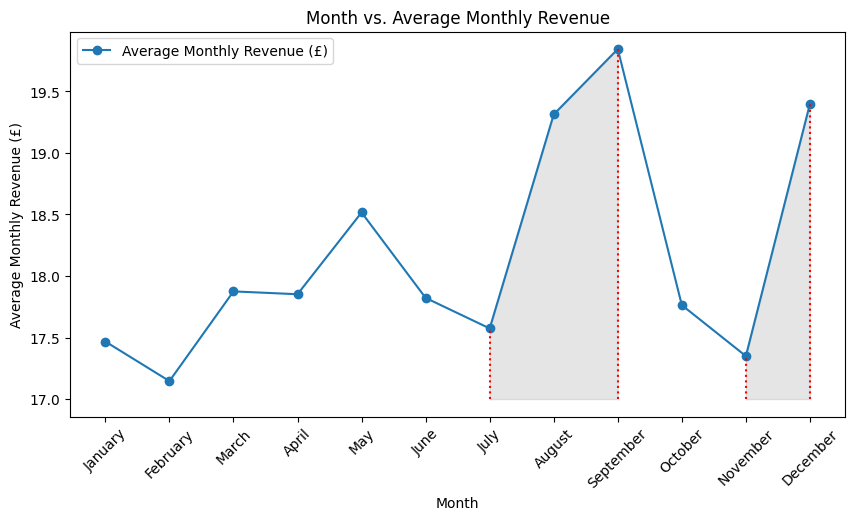

In [129]:
# Plot average monthly revenue for all of our data
plot_monthly_revenue(retail_data=retail_data)

The plot of Month Vs. Average Monthly Revenue, indicates that there could indeed be seasonal impact for revenue of our store. Betwen the months of July and Septmber, there is a clear increase in average monthly revenue followed by a steady decrease from September to November. From November to December, the average monthly revenue begins to swiftly increase again.  

The first thing we need to do is analyze our data for stationarity (exhibits trends of seasonality). ARIMA assumes stationarity so this will be important to know. We need to find the order of differencing (*d*) required to make the time series stationary.  

To check if our time series is stationary, we are going to use an Augmented Dickey Fullet (ADF) test (`adfuller()`) from statsmodel package. This is because you only need diffencing if the series is non-stationary. Otherwise, no differencing is needed (*d*=0). The null hypothesis of the ADF test is that the time series is non-stationary. If the p-value of the test is less than the significance level (0.05), reject the null hypothesis and infer that the time series is stationary (i.e. if p-value>0.05, go ahead with finding the order of differencing).  

Let's check revenue for stationarity for all 4 of our clusters.

### Analyzing Revenue Time Series Data on Daily Basis

In [130]:
# Create dataframes for all 4 clusters
cluster0_df = retail_data[retail_data['cluster']==0].sort_values(by='invoice_date')[['invoice_date', 'revenue']]
cluster1_df = retail_data[retail_data['cluster']==1].sort_values(by='invoice_date')[['invoice_date', 'revenue']]
cluster2_df = retail_data[retail_data['cluster']==2].sort_values(by='invoice_date')[['invoice_date', 'revenue']]
cluster3_df = retail_data[retail_data['cluster']==3].sort_values(by='invoice_date')[['invoice_date', 'revenue']]

# Split each cluster into train and test sets with rolling window  with 70% split point
cluster0_train, cluster0_test = train_test_split_time_series(cluster0_df, split_ratio=0.7)
cluster1_train, cluster1_test = train_test_split_time_series(cluster1_df, split_ratio=0.7)
cluster2_train, cluster2_test = train_test_split_time_series(cluster2_df, split_ratio=0.7)
cluster3_train, cluster3_test = train_test_split_time_series(cluster3_df, split_ratio=0.7)

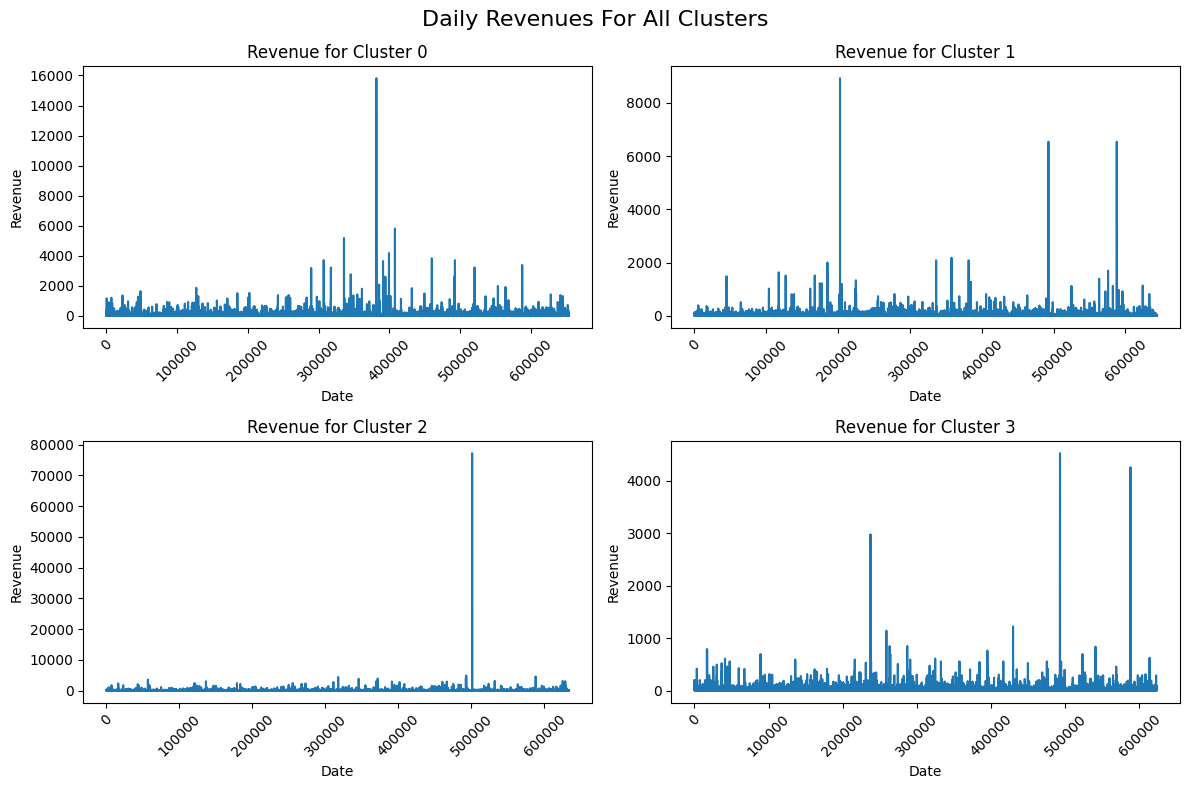

In [137]:
# Plot daily revenues for all clusters
dataframes = [cluster0_train, cluster1_train, cluster2_train, cluster3_train]
plot_cluster_revenues(dataframes, title='daily revenues for all clusters')

One of the things about this data making it very difficult to read is the frequency of days for our time series (making the plot look jagged). To address this, I will change the frequency of the date to weeks instead of days so it should give a more "smooth appearance" that is more interpretable.

There are clearly a few major outliers in each time series plot for each of our cluster. Outliers can introduce unnecessary noise to our data, providing our ARIMA model with a distorted view of what typical revenue looks like for our company. For cluster 0, the major outliers look like they are for any revenue greater than ~6000, for cluster 1, the outliers look to occur anything over about 3000, for cluster 2 anything over ~7000, and for cluster 3 anything over ~1500. Let's clip these outliers down to a certain threshold for each cluster and see if we get a more comprehensive view of our time series.


In [131]:
# Let's get a comprehensive view of what our top few values underneath our major outliers are for each cluster
top10_rev_cluster0 = cluster0_train['revenue'].nlargest(5).tolist()
top10_rev_cluster1 = cluster1_train['revenue'].nlargest(5).tolist()
top10_rev_cluster2 = cluster2_train['revenue'].nlargest(5).tolist()
top10_rev_cluster3 = cluster3_train['revenue'].nlargest(5).tolist()

# Create a dataframe of our results
top10_rev_dict = {'Top 5 Revenue - Cluster 0': top10_rev_cluster0, 'Top 5 Revenue - Cluster 1': top10_rev_cluster1, 
                  'Top 5 Revenue - Cluster 2': top10_rev_cluster2, 'Top 5 Revenue - Cluster 3': top10_rev_cluster3}
top10_rev_df = pd.DataFrame(top10_rev_dict)
top10_rev_df

,Top 5 Revenue - Cluster 0,Top 5 Revenue - Cluster 1,Top 5 Revenue - Cluster 2,Top 5 Revenue - Cluster 3
0,15818.40,8925.0,77183.60,4522.50
1,5803.25,6539.4,4921.50,4254.50
2,5179.20,6539.4,4632.00,2970.75
3,4176.00,2180.0,4464.72,2970.75
4,3828.00,2080.8,4121.64,1224.00


We can see that the difference in revenue between the outliers and the next highest value is the largest for Cluster 0, Cluster 1, and Cluster 2. To use clipping, I will set the new max of revenue to be the next highest value below the outlier for each cluster so we still keep statistical power. Cluster 3 does not have a huge difference between the max and the second highest so we will go down to the third highest point for the clipping threshold.

In [138]:
# Clip values in the 'value' column to a particular value if they exceed the threshold (the next highest value below the outlier)
threshold_0 = top10_rev_df.loc[1, 'Top 5 Revenue - Cluster 0']
threshold_1 = top10_rev_df.loc[1, 'Top 5 Revenue - Cluster 1']
threshold_2 = top10_rev_df.loc[1, 'Top 5 Revenue - Cluster 2']
threshold_3 = top10_rev_df.loc[2, 'Top 5 Revenue - Cluster 3']

cluster0_train['revenue'] = cluster0_train['revenue'].clip(upper=threshold_0)
cluster1_train['revenue'] = cluster1_train['revenue'].clip(upper=threshold_1)
cluster2_train['revenue'] = cluster2_train['revenue'].clip(upper=threshold_2)
cluster3_train['revenue'] = cluster3_train['revenue'].clip(upper=threshold_3)


Let's take a look at our daily time series after clipping...

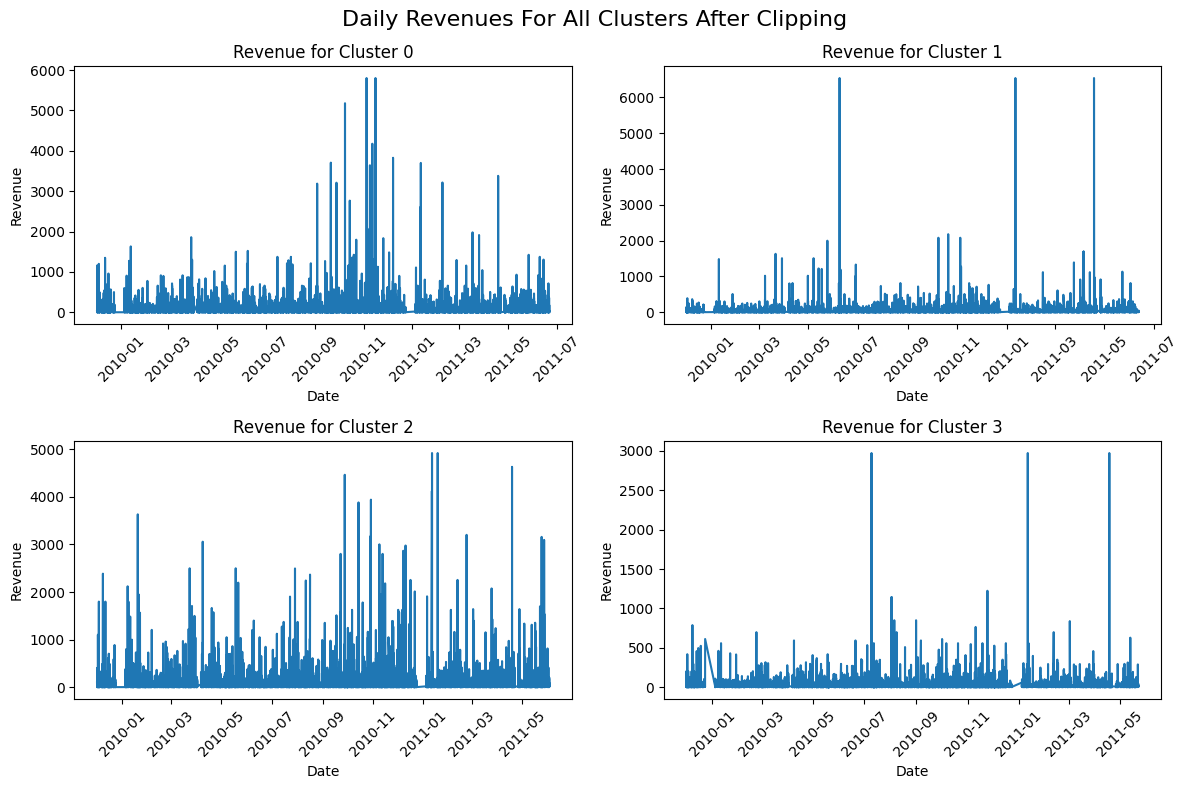

In [139]:
# Plot daily revenues for all clusters after clipping
dataframes = [cluster0_train, cluster1_train, cluster2_train, cluster3_train]
plot_cluster_revenues(dataframes, title='daily revenues for all clusters after clipping')

### Analyzing Revenue Time Series Data on Weekly Basis

In [140]:
# Resampling revenue on a weekly basis and creating series for each cluster train and test
cluster0_weekly_train, cluster0_weekly_test = create_weekly_splits(cluster0_train, cluster0_test)
cluster1_weekly_train, cluster1_weekly_test = create_weekly_splits(cluster1_train, cluster1_test)
cluster2_weekly_train, cluster2_weekly_test = create_weekly_splits(cluster2_train, cluster2_test)
cluster3_weekly_train, cluster3_weekly_test = create_weekly_splits(cluster3_train, cluster3_test)

# Concatenate train and test datasets to create one weekly for all data
cluster0_weekly = pd.concat([cluster0_weekly_train, cluster0_weekly_test], axis=0)
cluster1_weekly = pd.concat([cluster1_weekly_train, cluster1_weekly_test], axis=0)
cluster2_weekly = pd.concat([cluster2_weekly_train, cluster2_weekly_test], axis=0)
cluster3_weekly = pd.concat([cluster3_weekly_train, cluster3_weekly_test], axis=0)

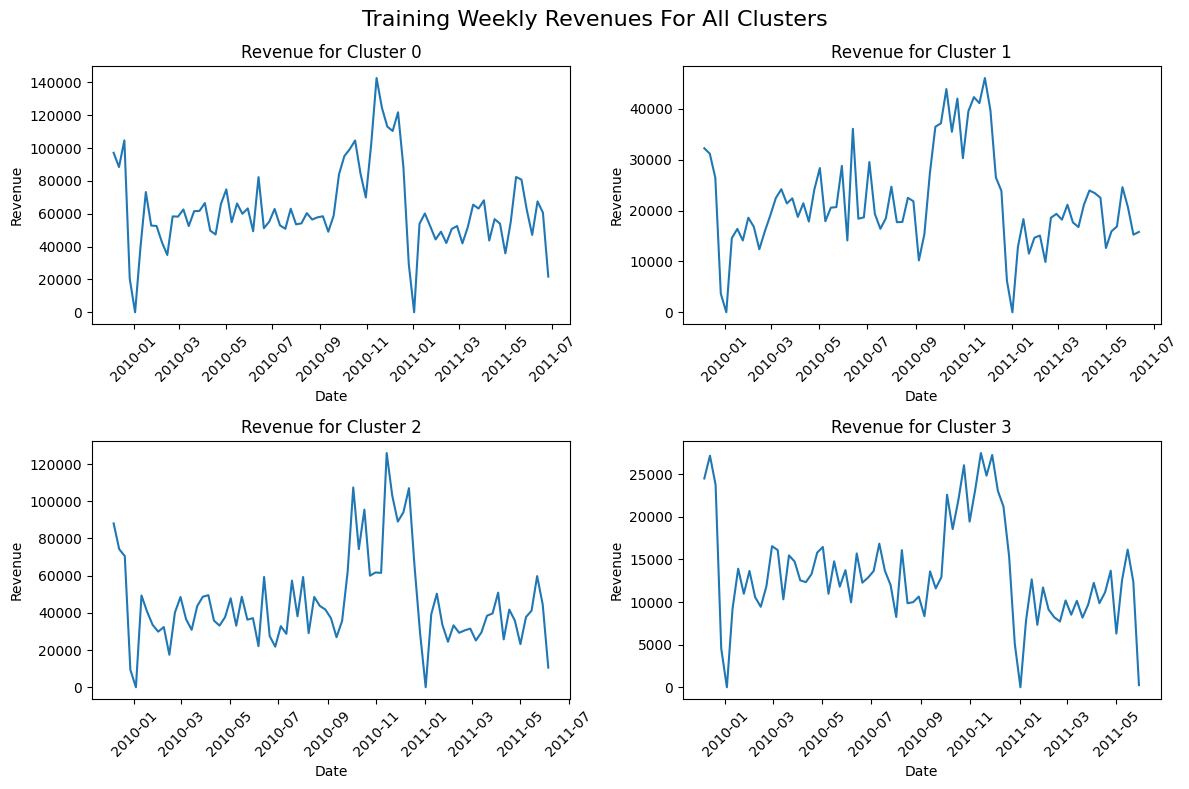

In [141]:
# Plot Weekly Revenue training datasets
dataframes_weekly_training = [cluster0_weekly_train, cluster1_weekly_train, cluster2_weekly_train, cluster3_weekly_train]
plot_cluster_revenues(dataframes_weekly_training, 'training weekly revenues for all clusters')

This looks much better! Now, let's save a few pd.series variables for revenue on a weekly basis because this makes our time series plots of revenue much more interpretable. 

### Checking for Stationarity  

Now, we will check for stationarity on all of the clusters to see if they require any differencing. Stationartiy essentially indicates that the time series has its statistical properties remain constant over time. We will first start with the Augmented Dickey-Fuller (ADF) test.

In [142]:
# Create list of training clusters
train_clusters = [cluster0_weekly_train, cluster1_weekly_train, cluster2_weekly_train, cluster3_weekly_train]

# Make dataframe of all ADF stats and p-values
adf_stats_train_clusters = adf_test_clusters(train_clusters)
adf_stats_train_clusters

,ADF Statistic,p-value
Cluster,,
0,-3.478445,0.008558
1,-3.846911,0.002462
2,-4.374945,0.000329
3,-3.789358,0.003018


**Cluster 0**  
Because our ADF statistic is -3.478445 and our p-value is 0.008558 (less than 0.05), we reject the null hypothesis that the time series for cluster 0 is non-stationary. The series for cluster 0 is indeed stationary.

**Cluster 1**  
Because our ADF statistic is -3.846911 and our p-value is 0.002462 (less than 0.05), we reject the null hypothesis that the time series for cluster 1 is non-stationary. The series for cluster 1 is indeed stationary.

**Cluster 2**  
Because our ADF statistic is -4.374945 and our p-value is 0.000329 (less than 0.05), we fail to reject the null hypothesis that the time series for cluster 2 is non-stationary.

**Cluster 3**  
Because our ADF statistic is -3.789358 and our p-value is 0.003018 (less than 0.05), we reject the null hypothesis that the time series for cluster 3 is non-stationary.

### ACF and PACF plots for Each Cluster  
Even though the Augmented Dickey-Fuller (ADF) test indicates that your time series is stationary and there is an indication that differencing (the "d" in ARIMA) is not required, we might still want to examine the ACF and PACF plots for other purposes, even if your data is stationary:
1. <u>Model Selection</u>: ACF and PACF plots can help you identify the orders (p and q) for the autoregressive (AR) and moving average (MA) components of an ARIMA model. While differencing may not be needed, you might still need to determine the appropriate values for p and q based on the ACF and PACF plots.
1. <u>Model Diagnostics</u>: Even if your data is stationary, it's essential to ensure that your model captures any remaining autocorrelation in the time series. ACF and PACF plots can help you assess whether the model adequately captures the serial correlation in the residuals.

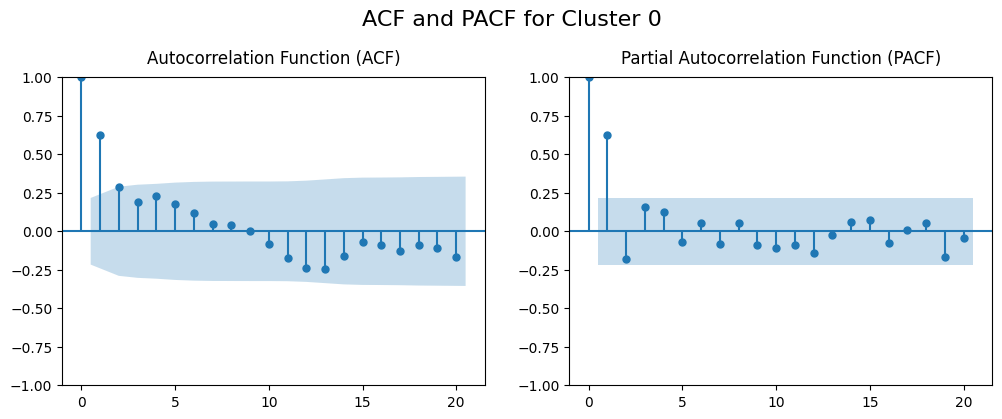

In [143]:
# Plot ACF and PACF for cluster 0 train
plot_acf_pacf(cluster0_weekly_train, cluster=0)

In [184]:
# Fit the ARIMA model on cluster0_weekly_train
arima_model_0 = ARIMA(cluster0_weekly_train, order=(2,0,1))
arima_model_0_fit = arima_model_0.fit()
print(arima_model_0_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   82
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -923.246
Date:                Wed, 25 Oct 2023   AIC                           1856.491
Time:                        22:01:08   BIC                           1868.525
Sample:                    12-06-2009   HQIC                          1861.323
                         - 06-26-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.293e+04   4328.662     14.538      0.000    5.44e+04    7.14e+04
ar.L1          0.4885      0.351      1.390      0.164      -0.200       1.177
ar.L2         -0.0236      0.248     -0.095      0.9

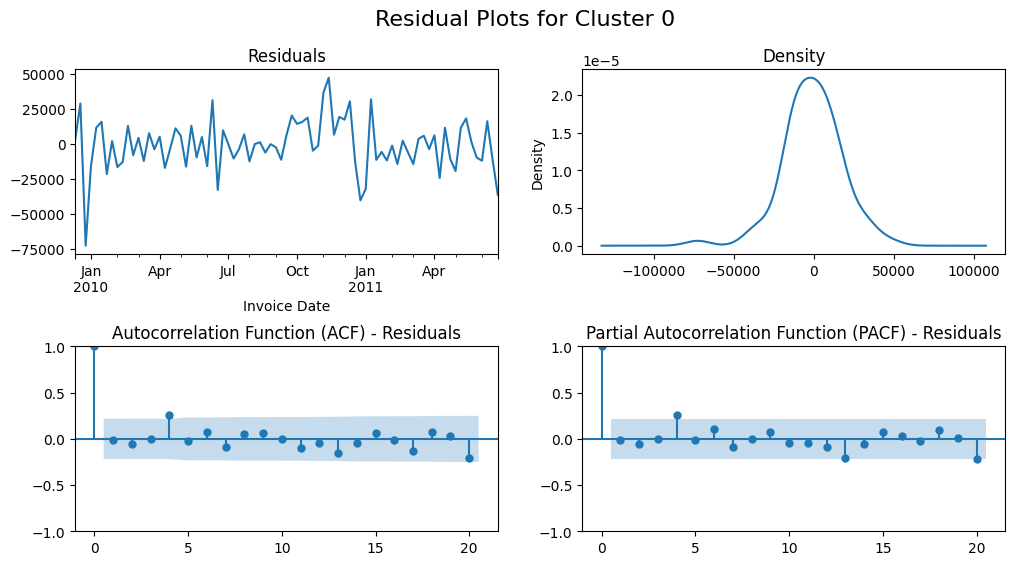

In [185]:
# Plot residuals of ARIMA model for cluster 0
plot_residuals_arima(arima_model_0_fit, cluster=0)

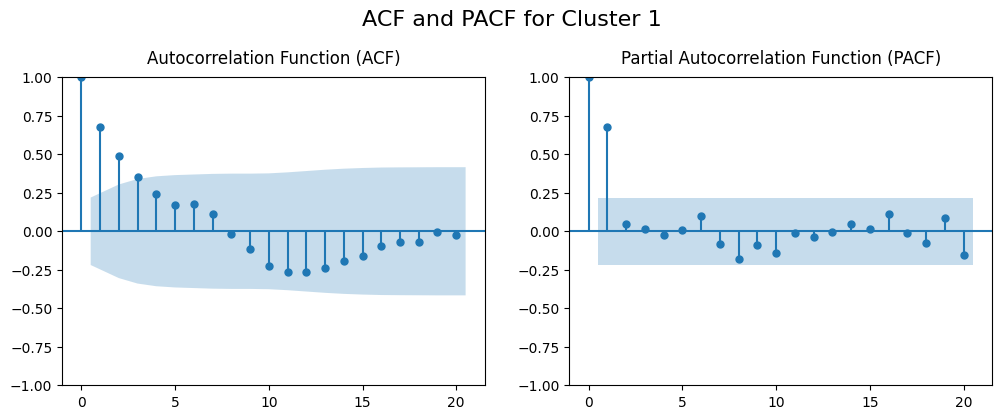

In [186]:
# Plot ACF and PACF for cluster 1 train
plot_acf_pacf(cluster1_weekly_train, cluster=1)

In [187]:
# Fit the ARIMA model on cluster1_weekly_train
arima_model_1 = ARIMA(cluster1_weekly_train, order=(2,0,1))
arima_model_1_fit = arima_model_1.fit()
print(arima_model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   80
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -821.166
Date:                Wed, 25 Oct 2023   AIC                           1652.332
Time:                        22:01:21   BIC                           1664.242
Sample:                    12-06-2009   HQIC                          1657.107
                         - 06-12-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.169e+04   2531.445      8.569      0.000    1.67e+04    2.67e+04
ar.L1          0.6743      1.603      0.421      0.674      -2.468       3.816
ar.L2          0.0379      1.098      0.035      0.9

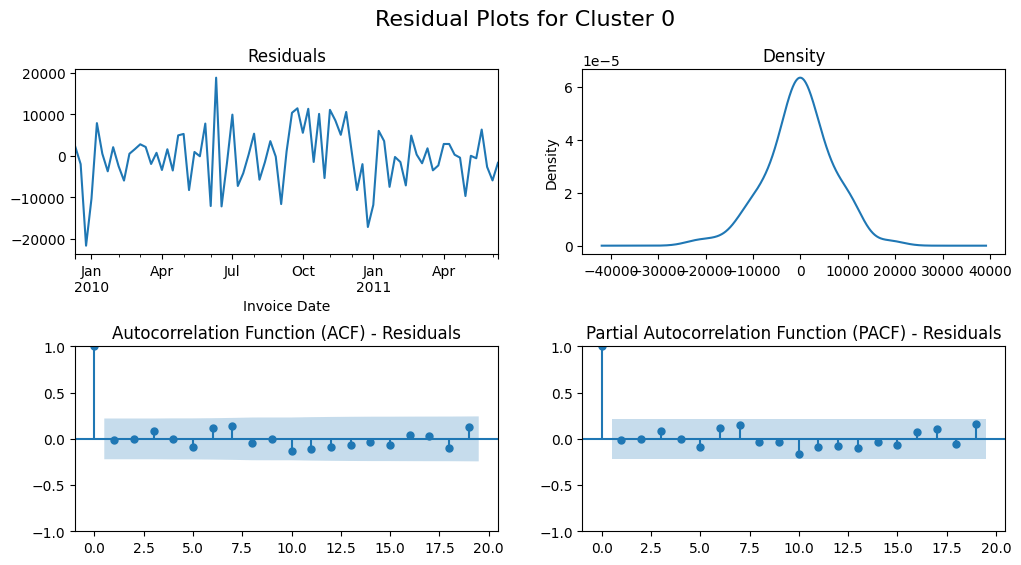

In [148]:
# Plot residuals of ARIMA model for cluster 1
plot_residuals_arima(arima_model_1_fit, cluster=0)

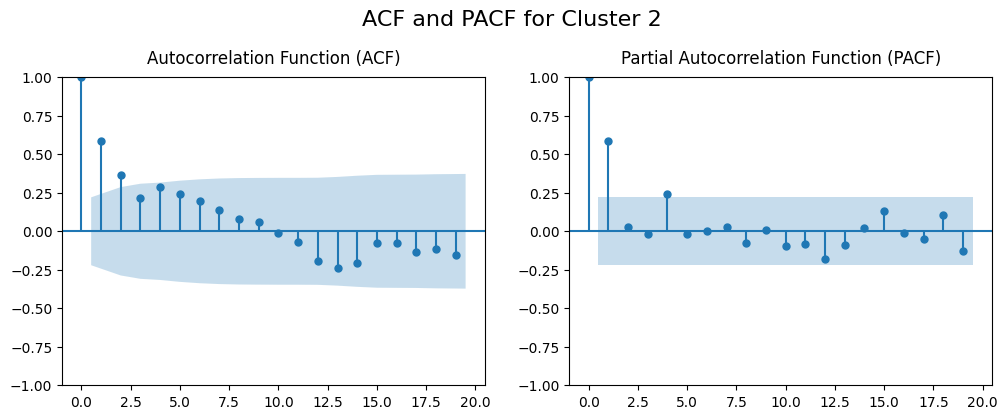

In [149]:
# Plot ACF and PACF for cluster 2 train
plot_acf_pacf(cluster2_weekly_train, cluster=2)

The ACF plot shows that the correlations with the lags are high and positive at the beginning and then decrease into the negative range at the end. The PACF shows that the partial autocorrelations have two large spikes and the beginining and then are marginally scattered throughout. 

Here, we see that compared to the original plot, the ACF value drops more quickly and the time series is less correlated to its lag. The PACF shows a less extreme spike in lag 1 which is a sign on the series being more stationary.  

Let's quantify our result by running the ADF test again on our differenced reveneue time series.

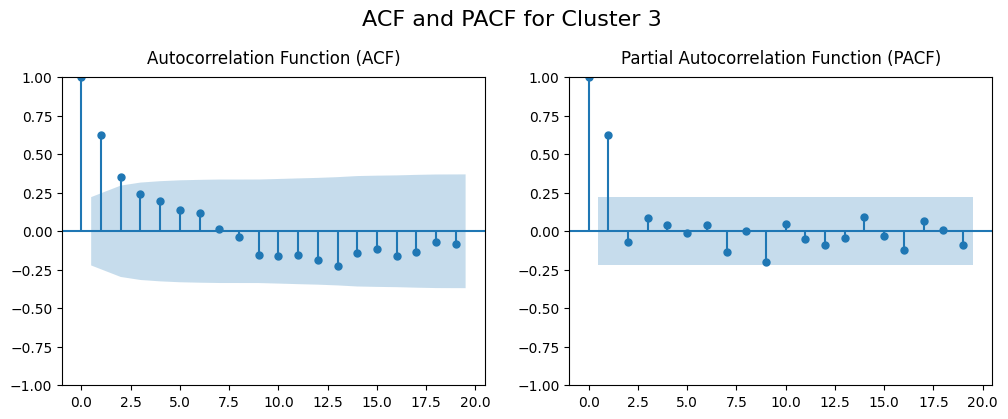

In [150]:
# Plot ACF and PACF for cluster 3 train
plot_acf_pacf(cluster3_weekly_train, cluster=3)

In [151]:
# Fit the ARIMA model on cluster3_weekly_train
arima_model_3 = ARIMA(cluster3_weekly_train, order=(2,0,1))
arima_model_3_fit = arima_model_3.fit()
print(arima_model_3_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   78
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -766.402
Date:                Wed, 25 Oct 2023   AIC                           1542.803
Time:                        21:44:41   BIC                           1554.587
Sample:                    12-06-2009   HQIC                          1547.520
                         - 05-29-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.339e+04   1654.067      8.097      0.000    1.02e+04    1.66e+04
ar.L1          0.3450      0.913      0.378      0.705      -1.444       2.134
ar.L2          0.1748      0.642      0.272      0.7

c:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


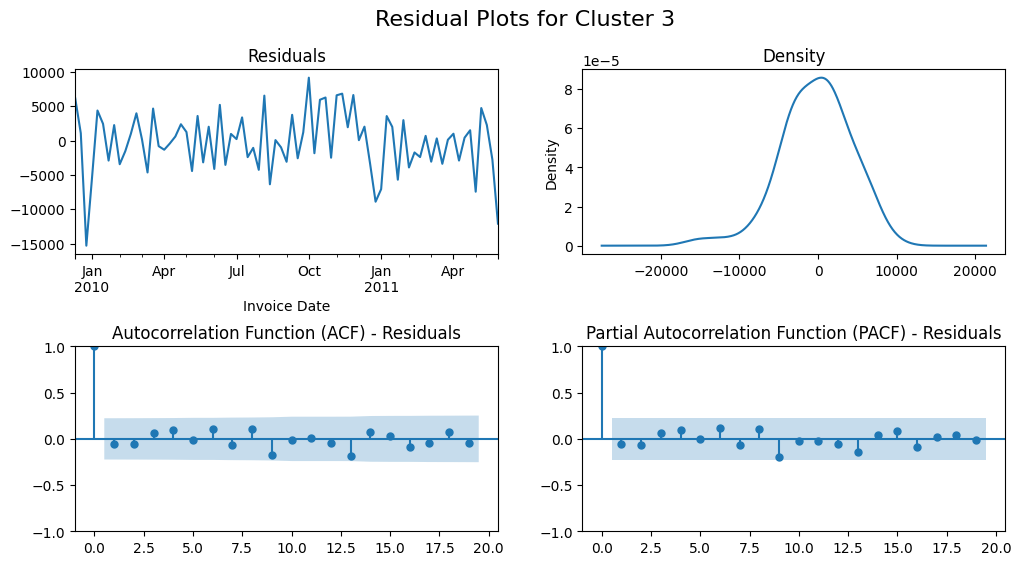

In [152]:
# Plot residuals of ARIMA model for cluster 3
plot_residuals_arima(arima_model_3_fit, cluster=3)

### Choosing the Appropriate Values for *p* and *q* Parameters  

To choose the appropriate values of *p* and *q* in our ARIMA model, we look at our ACF and PACF. There are two rules of thumb we need to follow:  
1. If the PACF plot has a significant spike at lag *p* but not beyond; the ACF plot decays more gradually. This may suggest an **ARIMA(*p*, *d*, 0)** model.
1. If the ACF plot has a significant spike at lag *q* but not beyond; the PACF plot decays more gradually. This may suggest an **ARIMA(0, *d*, *q*)** model.  

For our PACF, does have 1 small significant spike for the first lag and same for our ACF except that the ACF also has one additional in the second lag. In this case we will use an ARIMA (2,0,1) model

In [153]:
# Fit the ARIMA model on cluster2_weekly
arima_model = ARIMA(cluster2_weekly_train, order=(2,0,1))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   79
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -890.778
Date:                Wed, 25 Oct 2023   AIC                           1791.556
Time:                        21:44:48   BIC                           1803.404
Sample:                    12-06-2009   HQIC                          1796.303
                         - 06-05-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.526e+04   1.16e-06   3.91e+10      0.000    4.53e+04    4.53e+04
ar.L1         -0.3693      0.082     -4.524      0.000      -0.529      -0.209
ar.L2          0.6307      0.081      7.774      0.0

c:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Now, let's make sure that our model has captured adequate information from our data. We can check this by looking at the residuals. If the model fits our data well, the residuals should have no trend (look like noise). Let's plot the residuals and their densitry.

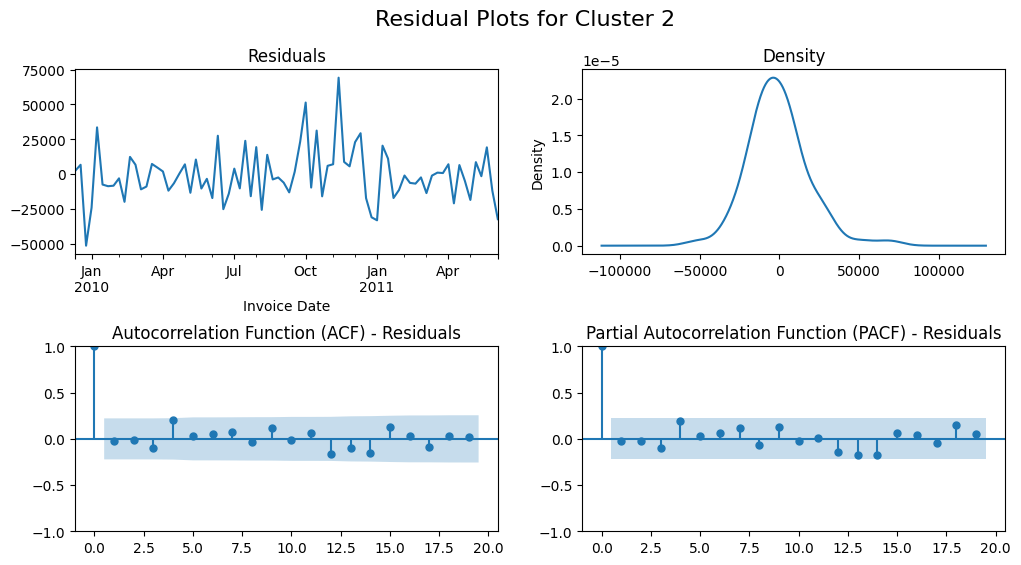

In [154]:
# Plot residuals of ARIMA model
plot_residuals_arima(arima_model_fit, cluster=2)

Because our residuals show no pattern and the distribution of our density looks normal with a mean around zero. The ACF and PACF plots do not show any significant spikes for the lower lag values. This is evidence that our residuals are close to random noise. Now, let's calculate predictions for this model.

In [233]:
cluster2_weekly_train.index.argmax()

78

In [215]:
cluster2_weekly.index[-1]

Timestamp('2011-12-11 00:00:00')

In [226]:
# Predict unseen data in the future
from pandas.tseries.offsets import DateOffset
future_dates = [cluster2_weekly.index[-1] + DateOffset(weeks=x) for x in range(0,10)]
future_dates_df = pd.DataFrame(index=future_dates[1:], columns=cluster2_weekly.columns)
# Merge future_dates_df with cluster2_weekly dataframe
future_df = pd.concat([cluster2_weekly, future_dates_df], axis=0)
future_df['forecast'] = arima_model_fit.predict(start=78, end=120, dynamic=False)
future_dates_df

,revenue,forecast_manual,forecast_auto
2011-12-18,NaN,NaN,NaN
2011-12-25,NaN,NaN,NaN
2012-01-01,NaN,NaN,NaN
2012-01-08,NaN,NaN,NaN
2012-01-15,NaN,NaN,NaN
2012-01-22,NaN,NaN,NaN
2012-01-29,NaN,NaN,NaN
2012-02-05,NaN,NaN,NaN
2012-02-12,NaN,NaN,NaN


In [227]:
# Merge future_dates_df with cluster2_weekly dataframe
future_df = pd.concat([cluster2_weekly, future_dates_df], axis=0)
future_df.index.max()

C:\Users\evans\AppData\Local\Temp\ipykernel_25368\3607966247.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df = pd.concat([cluster2_weekly, future_dates_df], axis=0)


Timestamp('2012-02-12 00:00:00')

<Axes: >

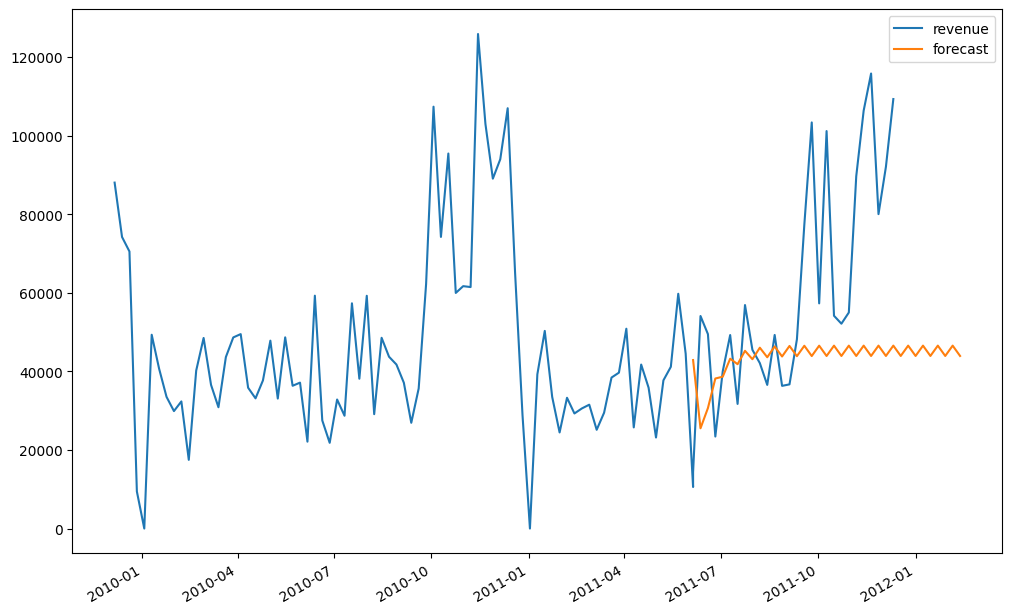

In [235]:
future_df['forecast'] = arima_model_fit.predict(start=78, end=120, dynamic=False)
future_df[['revenue', 'forecast']].plot(figsize=(12,8))

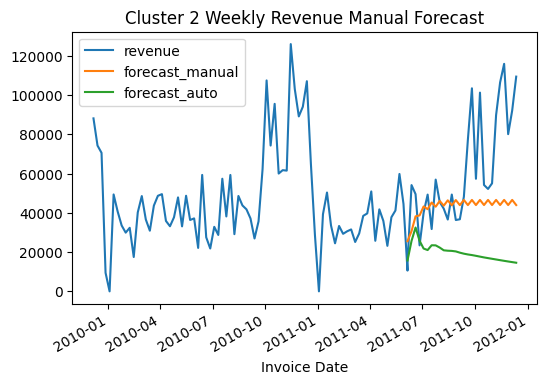

In [214]:
steps=4
# Plot predictions together with the actual series including the test set
forecast_test = arima_model_fit.forecast(steps=len(cluster2_weekly_test))
cluster2_weekly['forecast_manual'] = [None] * len(cluster2_weekly_train) + list(forecast_test)

# Create a figure with a specified size
fig, ax = plt.subplots(figsize=(6, 4)) 

cluster2_weekly.plot(ax=ax)

# Add the title
plt.title("Cluster 2 Weekly Revenue Manual Forecast")

# Add the x-label (xlabel)
plt.xlabel("Invoice Date")

plt.show()


This does not do a very good job predicting our revenue data. The actual revenue data oscilates but slowly starts to stagger up. Our prediction initially increases, following the upward trend and then starts to flatten out towards the end. Frotunately, we can Auto-fit our ARIMA model to get optimal paramters. Let's try that out below.

In [176]:
# Fit auto-ARIMA model for cluster 2
import pmdarima as pm
auto_arima = pm.auto_arima(cluster2_weekly_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(4, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [157]:
# Look at summary statistics for auto-ARIMA model
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -892.746
Date:                Wed, 25 Oct 2023   AIC                           1795.492
Time:                        21:45:11   BIC                           1807.339
Sample:                    12-06-2009   HQIC                          1800.238
                         - 06-05-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7021      0.088      7.978      0.000       0.530       0.875
ar.L2          0.0595      0.123      0.483      0.629      -0.182       0.301
ar.L3         -0.1368      0.115     -1.193      0.233      -0.362       0.088
ar.L4          0.3364      0.092      3.666      0.000       0.157       0.516
sigma2      3.323e+08    2.2e-10   1.51e+18      0.000    3.32e+08    3.32e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.89   Prob(JB):                         0.15
Heteroskedasticity (H):               1.00   Skew:                            -0.00
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+33. Standard errors may be unstable.
"""

Auto-ARIMA suggested that our best results might be SARIMAX(1,0,0) which accounts for seasonal components in the data compared to my ARIMA(2,0,1). Let's compare these two models on our test data.

In [177]:
# Fit auto-ARIMA model for cluster 0
import pmdarima as pm
auto_arima_0 = pm.auto_arima(cluster0_weekly_train, stepwise=False, seasonal=False)
auto_arima_0

ARIMA(order=(2, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [159]:
auto_arima_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -923.221
Date:                Wed, 25 Oct 2023   AIC                           1858.441
Time:                        21:45:24   BIC                           1872.882
Sample:                    12-06-2009   HQIC                          1864.239
                         - 06-26-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3988      0.203      1.961      0.050       0.000       0.797
ar.L2          0.5945      0.202      2.941      0.003       0.198       0.991
ma.L1          0.5616      0.210      2.676      0.007       0.150       0.973
ma.L2         -0.4782      0.114     -4.201      0.000      -0.701      -0.255
ma.L3         -0.5585      0.112     -4.988      0.000      -0.778      -0.339
sigma2      2.788e+08   5.11e-10   5.45e+17      0.000    2.79e+08    2.79e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                60.92
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.19
Prob(H) (two-sided):                  0.99   Kurtosis:                         6.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.51e+33. Standard errors may be unstable.
"""

In [178]:
# Fit auto-ARIMA model for cluster 1
import pmdarima as pm
auto_arima_1 = pm.auto_arima(cluster1_weekly_train, stepwise=False, seasonal=False)
auto_arima_1

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [161]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -826.419
Date:                Wed, 25 Oct 2023   AIC                           1658.839
Time:                        21:45:29   BIC                           1665.985
Sample:                    12-06-2009   HQIC                          1661.704
                         - 06-12-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9737      0.021     45.630      0.000       0.932       1.016
ma.L1         -0.2411      0.080     -3.009      0.003      -0.398      -0.084
sigma2      4.771e+07   3.19e-11    1.5e+18      0.000    4.77e+07    4.77e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.39
Prob(Q):                              0.98   Prob(JB):                         0.07
Heteroskedasticity (H):               0.85   Skew:                            -0.49
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.28e+34. Standard errors may be unstable.
"""

In [179]:
# Fit auto-ARIMA model for cluster 3
import pmdarima as pm
auto_arima_3 = pm.auto_arima(cluster3_weekly_train, stepwise=False, seasonal=False)
auto_arima_3

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [163]:
auto_arima_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   78
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -769.551
Date:                Wed, 25 Oct 2023   AIC                           1547.102
Time:                        21:45:35   BIC                           1556.528
Sample:                    12-06-2009   HQIC                          1550.875
                         - 05-29-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7075      0.102     16.711      0.000       1.507       1.908
ar.L2         -0.7075      0.102     -6.942      0.000      -0.907      -0.508
ma.L1         -0.9797      0.082    -11.957      0.000      -1.140      -0.819
sigma2       2.06e+07   1.72e-09    1.2e+16      0.000    2.06e+07    2.06e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                17.82
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.77
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+31. Standard errors may be unstable.
"""

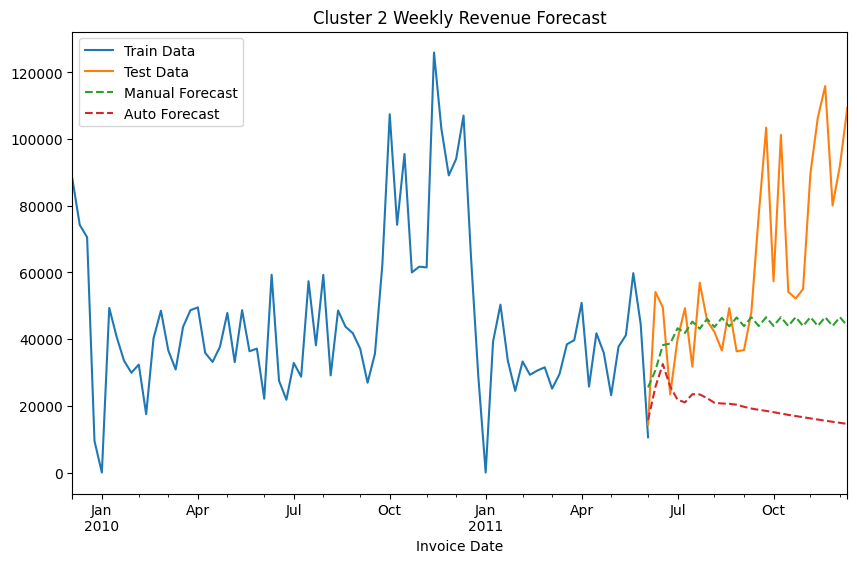

In [188]:
plot_manual_auto_forecasts(cluster2_weekly_test, cluster2_weekly_train, cluster2_weekly,
                             arima_model_fit, auto_arima, steps_ahead=1, title="Cluster 2 Weekly Revenue Forecast")

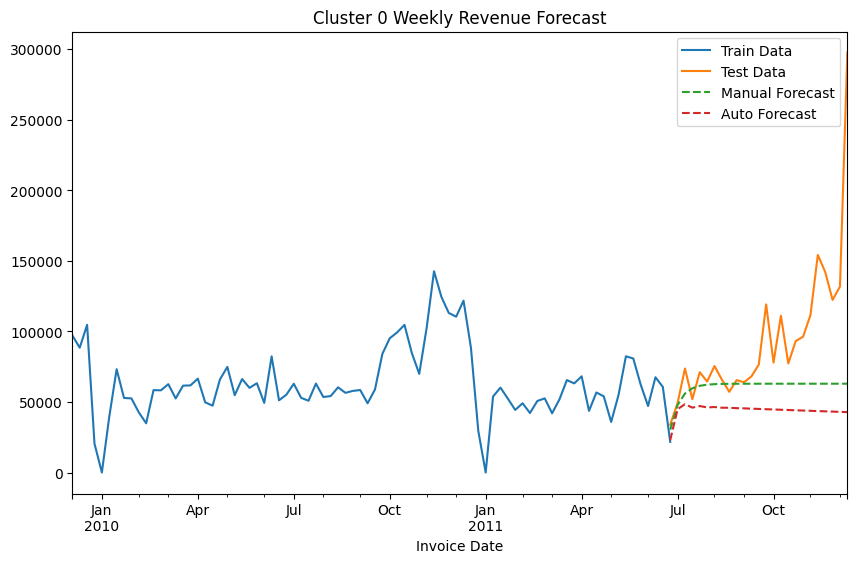

In [181]:
# Plot manual ARIMA and auto-ARIMA performance for Cluster 0
plot_manual_auto_forecasts(cluster0_weekly_test, cluster0_weekly_train, cluster0_weekly,
                             arima_model_0_fit, auto_arima_0, steps_ahead=1, title="Cluster 0 Weekly Revenue Forecast")

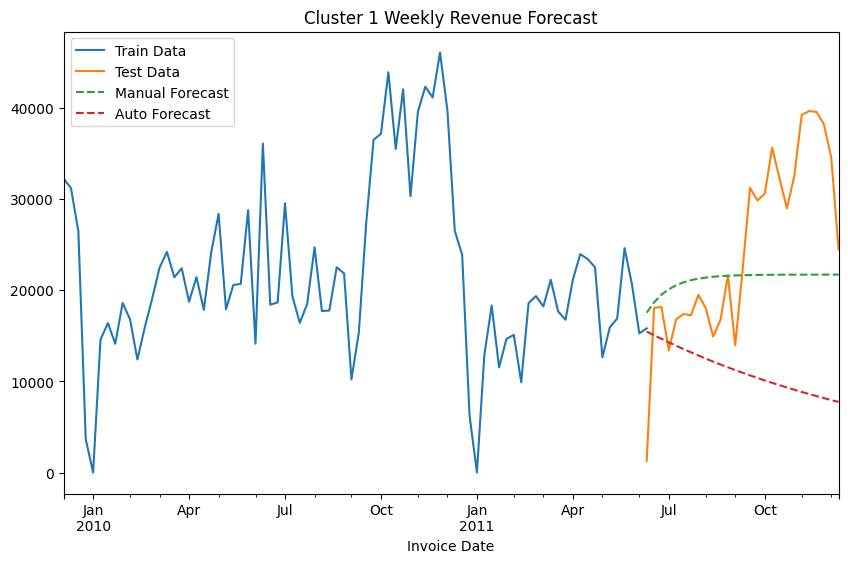

In [182]:
# Plot manual ARIMA and auto-ARIMA performance for Cluster 1
plot_manual_auto_forecasts(cluster1_weekly_test, cluster1_weekly_train, cluster1_weekly,
                             arima_model_1_fit, auto_arima_1, steps_ahead=1, title="Cluster 1 Weekly Revenue Forecast")

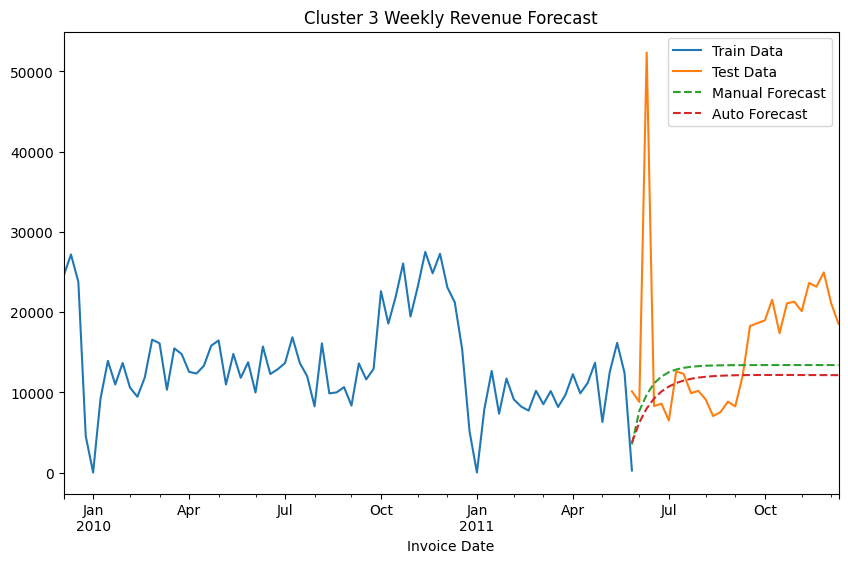

In [183]:
# Plot manual ARIMA and auto-ARIMA performance for Cluster 3
plot_manual_auto_forecasts(cluster3_weekly_test, cluster3_weekly_train, cluster3_weekly,
                             arima_model_3_fit, auto_arima_3, steps_ahead=1, title="Cluster 3 Weekly Revenue Forecast")